In [213]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sb
from sklearn import tree
from sklearn import svm
from sklearn.tree import plot_tree
from sklearn import ensemble
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [214]:
head_list = ["nTracks","nShowers","nVertex","trkE","EmE","pidaLong","pidaShort","lenLong","lenShort","visE","pLong","trackEfrac","nFlashes","flashPE","sig"]
atmo = pd.read_csv("atmotree.csv",names=head_list,header=None,index_col=False)
pdk = pd.read_csv("pdktree.csv",names=head_list,header=None,index_col=False)

# Signal and background csvs are imported, as well as necessary libraries. Look to see they have expected behavior.

In [215]:
#atmo=atmo[0:1633]
atmo.count()

nTracks       2223
nShowers      2223
nVertex       2223
trkE          2223
EmE           2223
pidaLong      2223
pidaShort     2223
lenLong       2223
lenShort      2223
visE          2223
pLong         2223
trackEfrac    2223
nFlashes      2223
flashPE       2223
sig           2223
dtype: int64

In [216]:
#pdk=pdk[0:2500]
pdk.count()

nTracks       3170
nShowers      3170
nVertex       3170
trkE          3170
EmE           3170
pidaLong      3170
pidaShort     3170
lenLong       3170
lenShort      3170
visE          3170
pLong         3170
trackEfrac    3170
nFlashes      3170
flashPE       3170
sig           3170
dtype: int64

In [217]:
pdk_df = atmo
pdk_df=pdk_df.append(pdk,ignore_index=True)
pdk_df=pdk_df.drop(["trkE","EmE","visE"],axis=1)
pdk_df.count()

nTracks       5393
nShowers      5393
nVertex       5393
pidaLong      5393
pidaShort     5393
lenLong       5393
lenShort      5393
pLong         5393
trackEfrac    5393
nFlashes      5393
flashPE       5393
sig           5393
dtype: int64

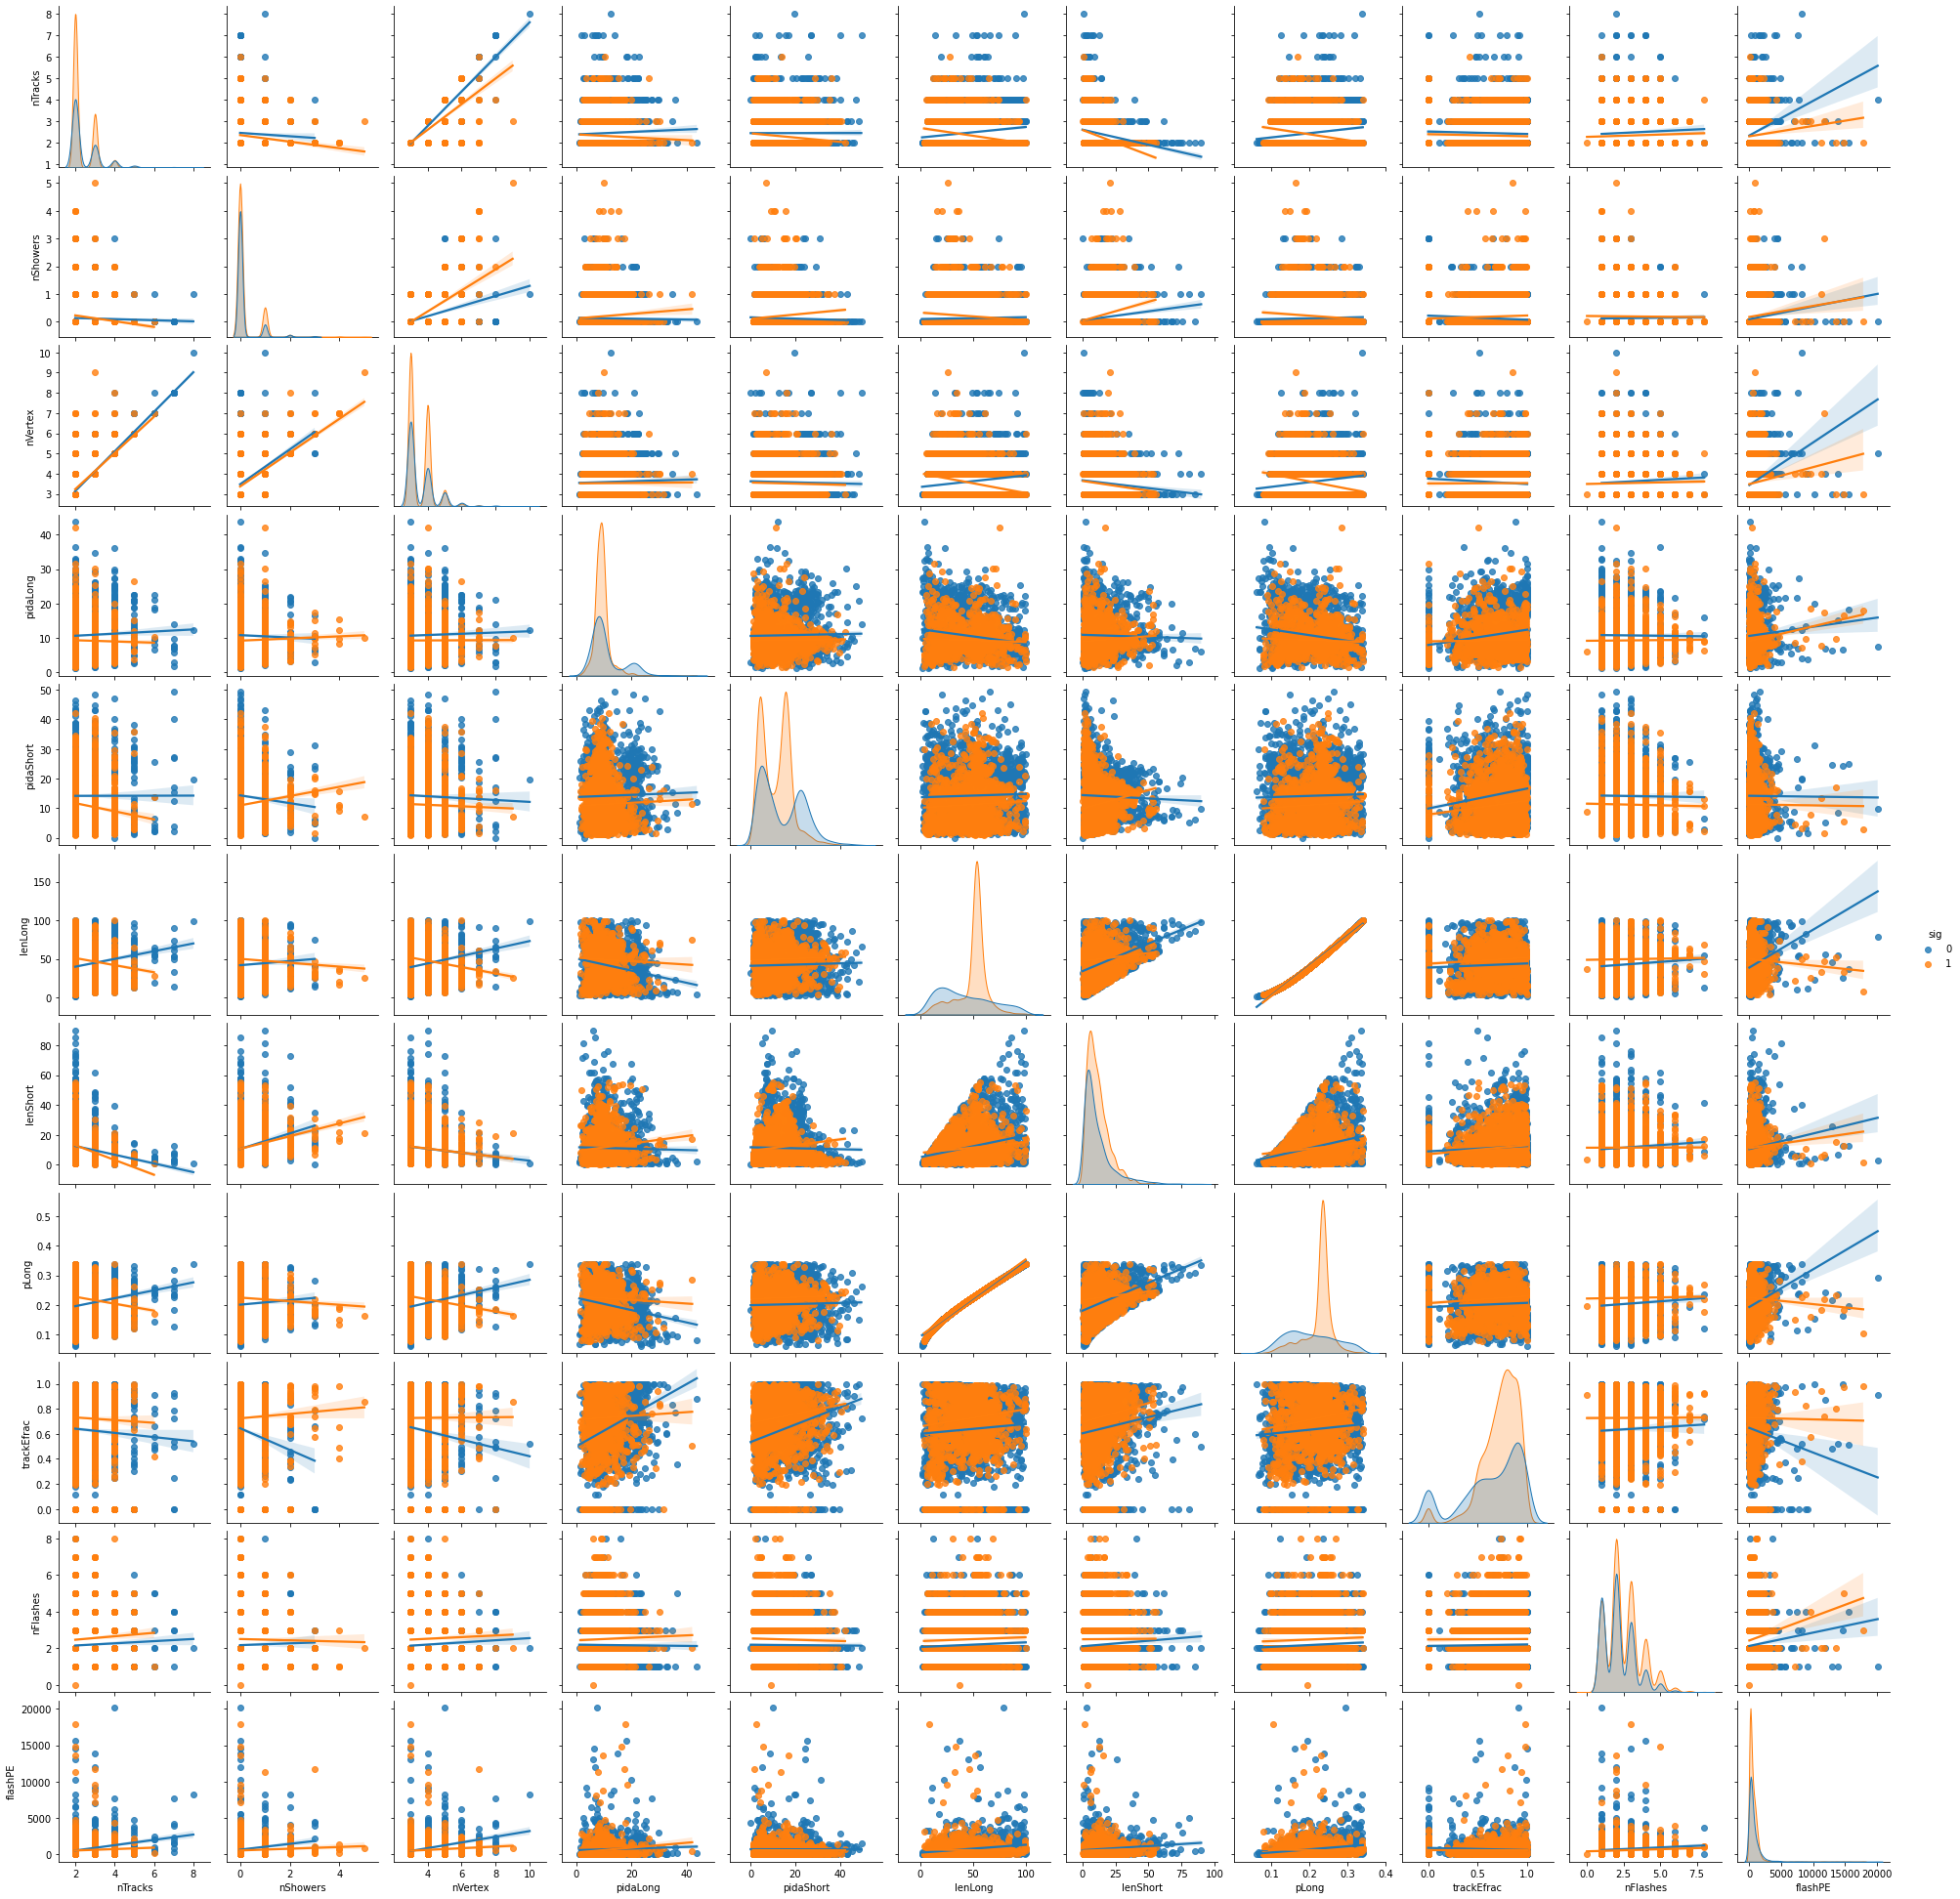

In [218]:
sb.pairplot(data=pdk_df,kind="reg",hue="sig")

In [219]:
pdk_target = pdk_df.sig

### Pull off the "signal" column to use as the target for our ML models

In [220]:
pdk_target
pdk_df=pdk_df.drop(["sig"],axis=1)

### Use 70% of the sample as a training set, and split here. Have a look to make sure it makes sense

In [221]:
X_train, X_test, y_train, y_test =train_test_split(pdk_df, pdk_target, test_size = 0.3)
X_train.head()

nTracks  nShowers  nVertex  pidaLong  pidaShort  lenLong  lenShort  \
5367        2         0        3   9.81512   15.34700  53.2863  13.53730   
5165        2         0        3   9.62576   13.04770  55.2511  15.34780   
2148        2         0        3   6.40346    2.49536  23.1960   3.08981   
1483        3         0        4   9.05674    4.54893  30.1637   3.17911   
863         2         0        3   7.55770   11.78360  29.6538  12.10670   

         pLong  trackEfrac  nFlashes  flashPE  
5367  0.233964    0.852047         2  571.591  
5165  0.238629    0.684334         3  664.414  
2148  0.155950    0.497505         1  724.851  
1483  0.175699    0.000000         3  254.999  
863   0.174301    0.405171         3  258.947

In [222]:
y_train.head()

5367    1
5165    1
2148    0
1483    0
863     0
Name: sig, dtype: int64

## Here we make our ML models. First a decision tree, we do nothing special to it and let it find its own path

In [223]:
clf=tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

DecisionTreeClassifier()

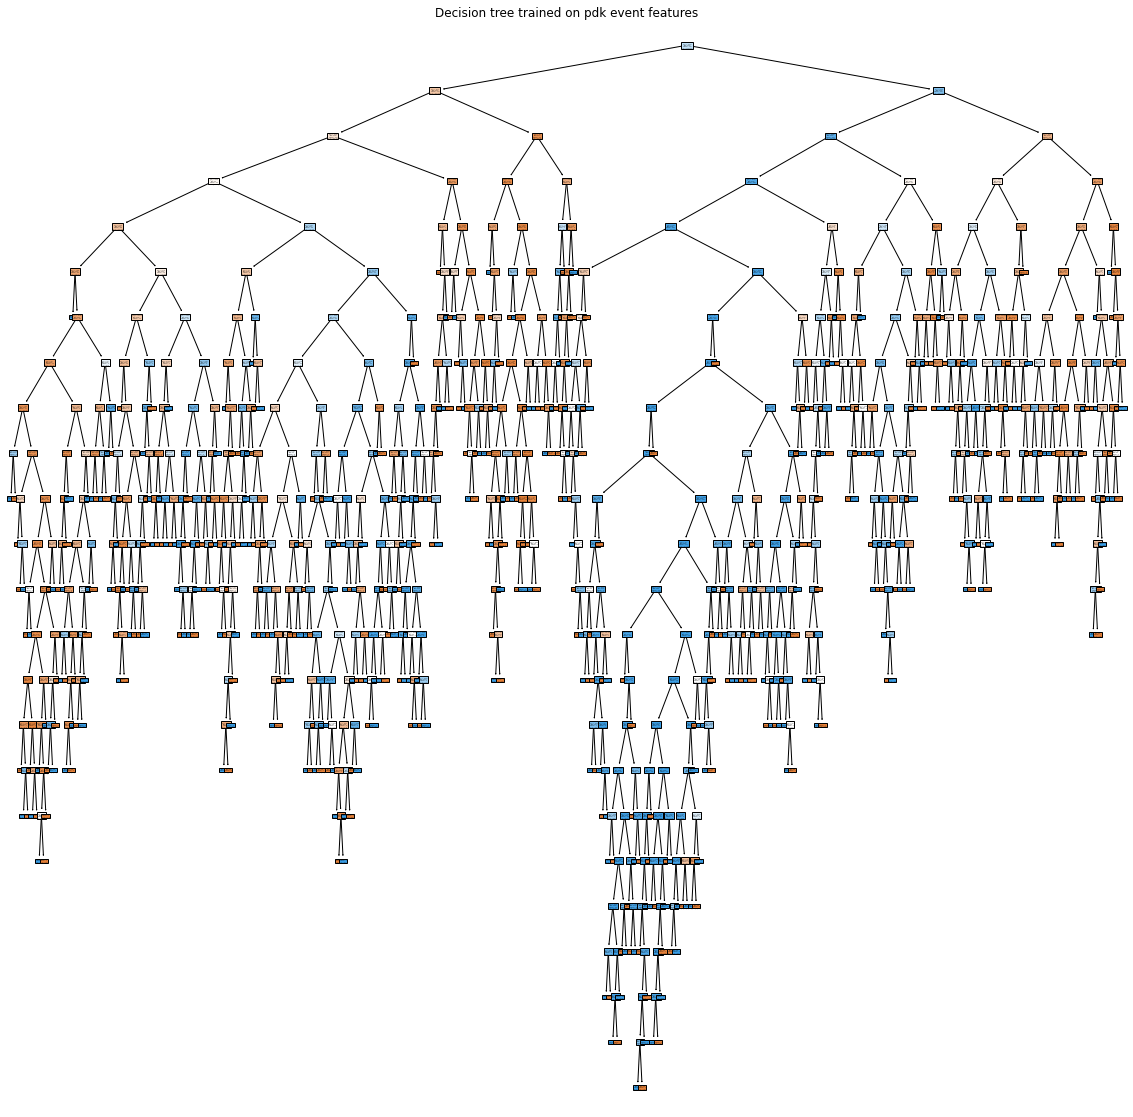

In [224]:

plt.figure(figsize=[20,20])
plot_tree(clf, filled=True)
plt.title("Decision tree trained on pdk event features")
plt.show()

In [225]:
clf.predict(X_test)

array([0, 0, 1, ..., 0, 1, 1])

In [226]:
clf_score = clf.score(X_test,y_test)
print("The score of the Decision tree classifier is ", clf_score )

The score of the Decision tree classifier is  0.7911001236093943


In [227]:
for i in ["sig","trkE","EmE","visE"]:
    head_list.remove(i)

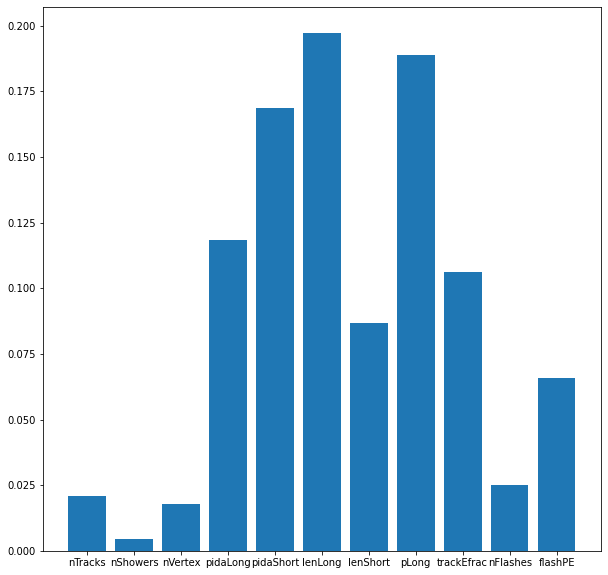

In [228]:
plt.figure(figsize=[10,10])
plt.bar(head_list,clf.feature_importances_)
plt.xlabel="Feature"
plt.ylabel="Importance"
plt.show()

## Here we try a Gradient Boosting Classifier

In [229]:
gbc = ensemble.GradientBoostingClassifier()

In [230]:
gbc.fit(X_train,y_train)
gbc_preds=gbc.predict(X_test)

In [231]:
gbc_score= gbc.score(X_test,y_test)
print(gbc_score)

0.8411619283065513


It does pretty okay, but can we improve some

In [232]:
classification_report(y_test,gbc_preds)

'              precision    recall  f1-score   support\n\n           0       0.83      0.78      0.80       680\n           1       0.85      0.89      0.87       938\n\n    accuracy                           0.84      1618\n   macro avg       0.84      0.83      0.84      1618\nweighted avg       0.84      0.84      0.84      1618\n'

In [233]:
confusion_matrix(y_test,gbc_preds)

array([[530, 150],
       [107, 831]])

In [234]:
y_scores_gb = gbc.decision_function(X_test)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

Area under ROC curve = 0.91


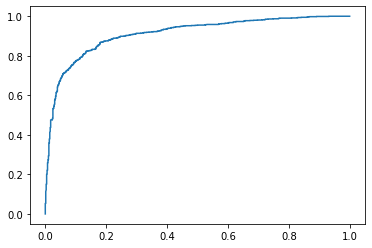

In [235]:
plt.figure()
plt.plot(fpr_gb,tpr_gb)

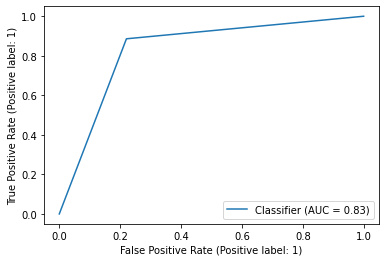

In [236]:
RocCurveDisplay.from_predictions(y_test,gbc_preds)

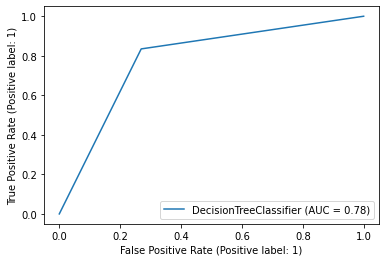

In [237]:
RocCurveDisplay.from_estimator(clf,X_test,y_test)

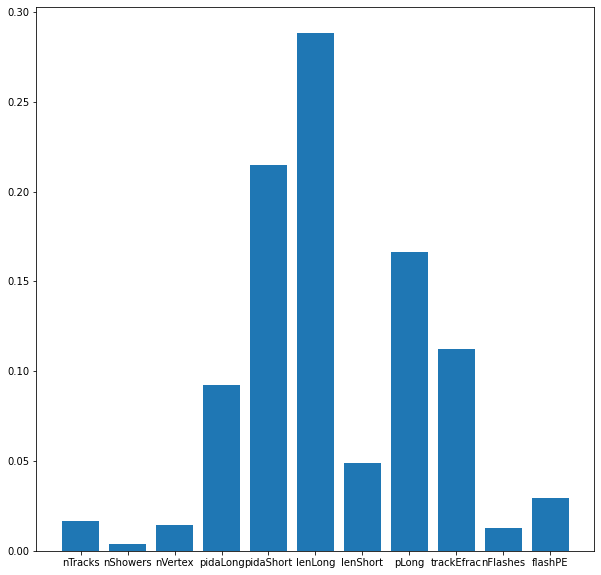

In [238]:
plt.figure(figsize=[10,10])
plt.bar(head_list,gbc.feature_importances_)
plt.xlabel="Feature"
plt.ylabel="Importance"
plt.show()

In [239]:
gbc.feature_importances_

array([0.01648655, 0.00388256, 0.01417033, 0.09213999, 0.21499031,
       0.28829696, 0.0491124 , 0.1665708 , 0.1126148 , 0.01253326,
       0.02920206])

## What about an SVC? 

In [240]:
svc = svm.NuSVC()
svc.fit(X_train,y_train)
svc_score=svc.score(X_test,y_test)
print (svc_score)

0.6594561186650185


In [241]:

rfC = RandomForestClassifier()
rfC.fit(X_train,y_train)
rfC_score=rfC.score(X_test,y_test)
print (rfC_score)

0.853522867737948


<BarContainer object of 11 artists>

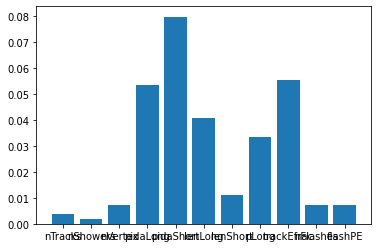

In [242]:

pImp = permutation_importance(rfC,X_test,y_test,n_repeats=10,random_state=0)
pImp_df = pd.DataFrame(columns=['Importance'],index = [i for i in X_train.columns])
pImp_df['Importance']= pImp.importances_mean
pImp_df
plt.bar(pImp_df.index,pImp_df.Importance)


In [243]:

NBC = GaussianNB()
NBC.fit(X_train,y_train)
NBC_score = NBC.score(X_test,y_test)
print(NBC_score)

0.7484548825710754


In [244]:

nnCLF = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10,10, 5,3,2), random_state=3)
nnCLF.fit(X_train,y_train)
nnCLF_score=nnCLF.score(X_test,y_test)
print(nnCLF_score)

0.5815822002472187


In [245]:

nnCLF = MLPClassifier(solver = 'adam', learning_rate='invscaling', verbose = 1,random_state=8)
nnCLF.fit(X_train,y_train)
nnCLF_score=nnCLF.score(X_test,y_test)
print(nnCLF_score)

Iteration 1, loss = 5.05385612
Iteration 2, loss = 1.91175210
Iteration 3, loss = 1.01727154
Iteration 4, loss = 0.75895387
Iteration 5, loss = 0.68903277
Iteration 6, loss = 0.66404144
Iteration 7, loss = 0.70566497
Iteration 8, loss = 0.64538967
Iteration 9, loss = 0.59681833
Iteration 10, loss = 0.60887372
Iteration 11, loss = 0.68451817
Iteration 12, loss = 0.64075137
Iteration 13, loss = 0.65947309
Iteration 14, loss = 0.59056457
Iteration 15, loss = 0.66789230
Iteration 16, loss = 0.70621647
Iteration 17, loss = 0.67825454
Iteration 18, loss = 0.56576672
Iteration 19, loss = 0.62662486
Iteration 20, loss = 0.57225503
Iteration 21, loss = 0.54772462
Iteration 22, loss = 0.56180607
Iteration 23, loss = 0.56962775
Iteration 24, loss = 0.68497253
Iteration 25, loss = 0.57348689
Iteration 26, loss = 0.57114162
Iteration 27, loss = 0.53898056
Iteration 28, loss = 0.69447616
Iteration 29, loss = 0.71041744
Iteration 30, loss = 0.54929398
Iteration 31, loss = 0.61726382
Iteration 32, los

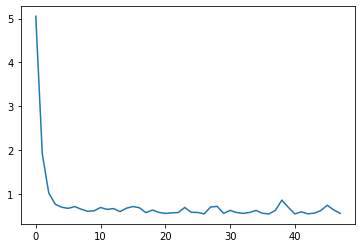

In [246]:
plt.plot(nnCLF.loss_curve_)
#plt.plot(nnCLF.validation_scores_)

In [247]:

neigh = KNeighborsClassifier(n_neighbors=5,weights = 'distance',algorithm='auto')
neigh.fit(X_train,y_train)
neigh_score=neigh.score(X_test,y_test)
print(neigh_score)

0.723114956736712


# OKAY, let us do the same thing but for the flash matched set

In [248]:
head_list = ["nTracks","nShowers","nVertex","trkE","EmE","pidaLong","pidaShort","lenLong","lenShort","visE","pLong","trackEfrac","nFlashes","flashPE","sig"]
atmo_flash = pd.read_csv("atmotree_flash.csv",names=head_list,header=None,index_col=False)
pdk_flash = pd.read_csv("pdktree_flash.csv",names=head_list,header=None,index_col=False)

# Signal and background csvs are imported, as well as necessary libraries. Look to see they have expected behavior.

In [249]:
#atmo_flash=atmo_flash[0:1633]
atmo_flash.count()

nTracks       2228
nShowers      2228
nVertex       2228
trkE          2228
EmE           2228
pidaLong      2228
pidaShort     2228
lenLong       2228
lenShort      2228
visE          2228
pLong         2228
trackEfrac    2228
nFlashes      2228
flashPE       2228
sig           2228
dtype: int64

In [250]:
#pdk_flash=pdk_flash[0:2500]
pdk_flash.count()

nTracks       3172
nShowers      3172
nVertex       3172
trkE          3172
EmE           3172
pidaLong      3172
pidaShort     3172
lenLong       3172
lenShort      3172
visE          3172
pLong         3172
trackEfrac    3172
nFlashes      3172
flashPE       3172
sig           3172
dtype: int64

In [251]:
pdk_fdf = atmo_flash
pdk_fdf=pdk_fdf.append(pdk_flash,ignore_index=True)
pdk_fdf=pdk_fdf.drop(["trkE","EmE","visE"],axis=1)
pdk_fdf.count()

nTracks       5400
nShowers      5400
nVertex       5400
pidaLong      5400
pidaShort     5400
lenLong       5400
lenShort      5400
pLong         5400
trackEfrac    5400
nFlashes      5400
flashPE       5400
sig           5400
dtype: int64

In [252]:
import seaborn as sb

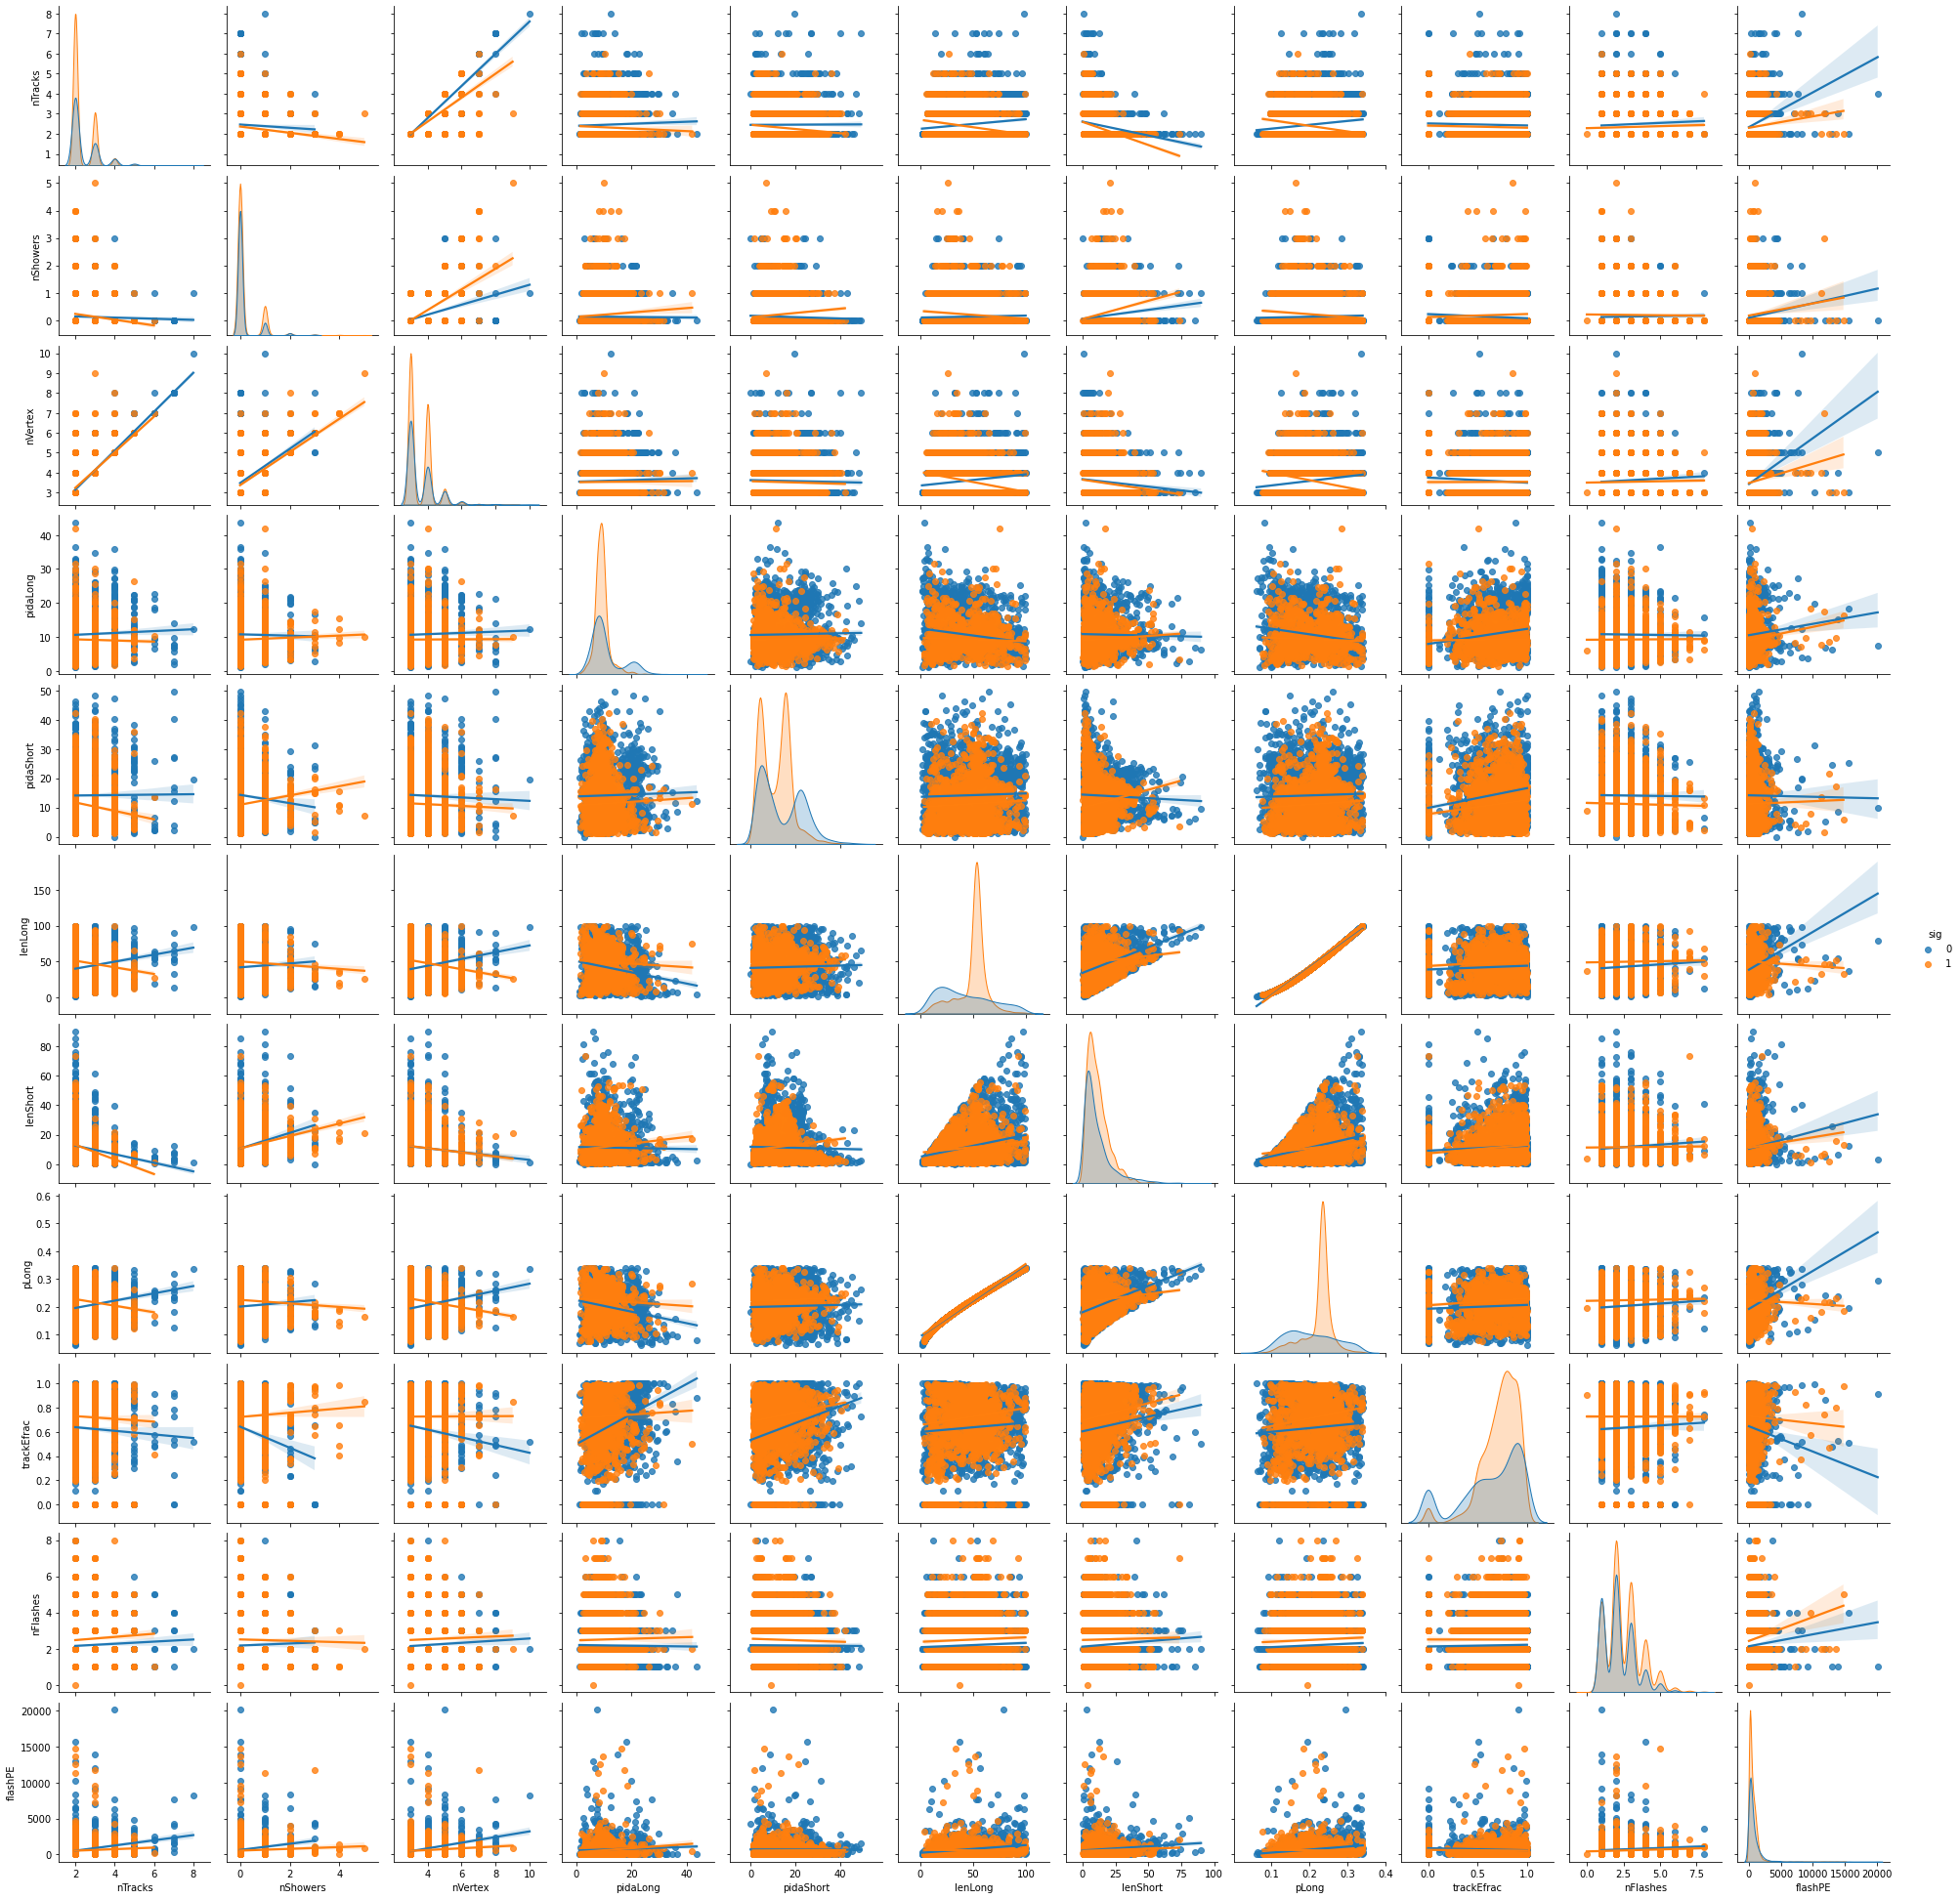

In [253]:
sb.pairplot(data=pdk_fdf,kind="reg",hue="sig")

In [254]:
pdk_ftarget = pdk_fdf.sig

# Pull off the "signal" column to use as the target for our ML models

In [255]:
pdk_ftarget
pdk_fdf=pdk_fdf.drop(["sig"],axis=1)

# Use 70% of the sample as a training set, and split here. Have a look to make sure it makes sense

In [256]:
Xf_train, Xf_test, yf_train, yf_test =train_test_split(pdk_fdf, pdk_ftarget, test_size = 0.3)
Xf_train.head()

nTracks  nShowers  nVertex  pidaLong  pidaShort   lenLong  lenShort  \
1133        2         0        3   7.87590    7.35500  38.20620  17.81050   
643         2         0        3   4.64545    3.14537   8.64448   3.94367   
1562        2         1        4   9.27551    2.02268  56.34050   1.89231   
693         2         0        3   4.90761   16.65680  85.95260  44.05320   
94          2         0        3  18.06350   11.79410  19.72650   4.42990   

         pLong  trackEfrac  nFlashes   flashPE  
1133  0.196929    0.508433         2   84.2052  
643   0.105217    0.539855         3  122.2870  
1562  0.241203    0.652104         3  393.5420  
693   0.308884    0.979311         4  294.8430  
94    0.145526    0.000000         1   33.5468

In [343]:
yf_train.head()

1133    0
643     0
1562    0
693     0
94      0
Name: sig, dtype: int64

In [258]:
from sklearn import tree
from sklearn import svm

# Here we make our ML models. First a decision tree, we do nothing special to it and let it find its own path

In [259]:
Fclf=tree.DecisionTreeClassifier()
Fclf.fit(Xf_train,yf_train)

DecisionTreeClassifier()

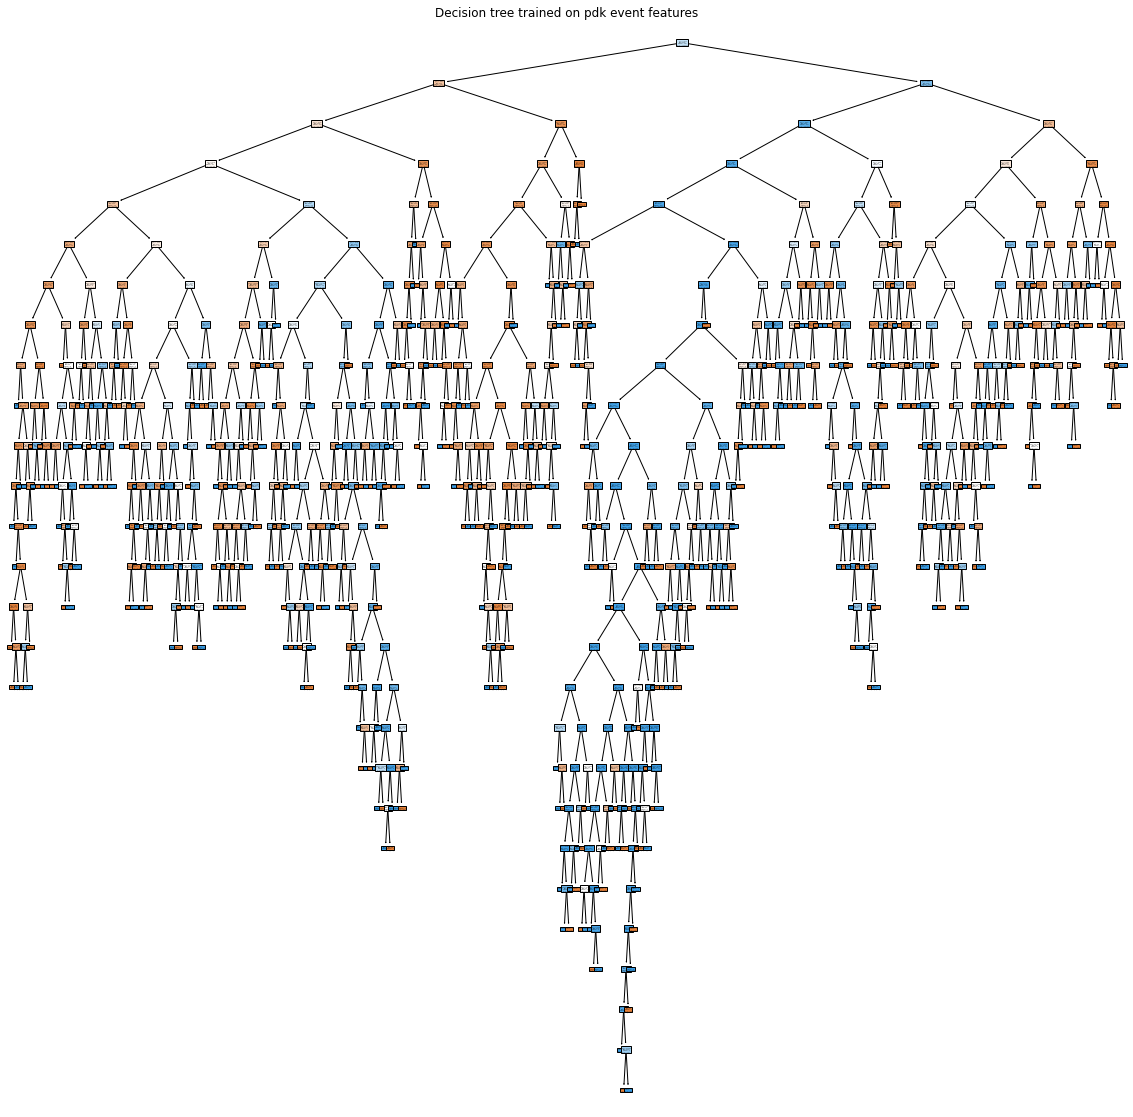

In [260]:
from sklearn.tree import plot_tree
plt.figure(figsize=[20,20])
plot_tree(Fclf, filled=True)
plt.title("Decision tree trained on pdk event features")
plt.show()

In [261]:
Fclf.predict(X_test)

array([0, 0, 1, ..., 0, 1, 1])

In [262]:
Fclf_score= Fclf.score(X_test,y_test)
print("The score of the Decision tree classifier is ", Fclf_score)

The score of the Decision tree classifier is  0.9332509270704573


In [263]:
for i in ["sig","trkE","EmE","visE"]:
    head_list.remove(i)

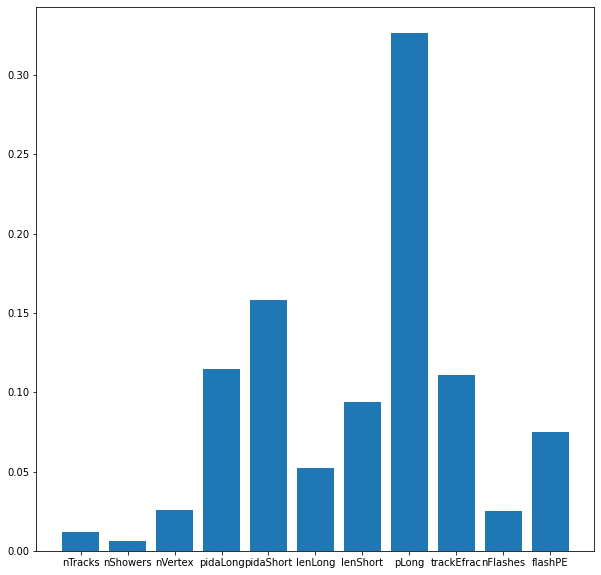

In [264]:
plt.figure(figsize=[10,10])
plt.bar(head_list,Fclf.feature_importances_)
plt.xlabel="Feature"
plt.ylabel="Importance"
plt.show()

# Here we try a Gradient Boosting Classifier

In [265]:
from sklearn import ensemble
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

In [266]:
Fgbc = ensemble.GradientBoostingClassifier()

In [267]:
Fgbc.fit(Xf_train,yf_train)
Fgbc_preds=gbc.predict(Xf_test)

In [268]:
Fgbc_score = Fgbc.score(Xf_test,yf_test)
print(Fgbc_score)

0.832716049382716


It does pretty okay, but can we improve some

In [269]:
classification_report(yf_test,Fgbc_preds)

'              precision    recall  f1-score   support\n\n           0       0.86      0.80      0.83       669\n           1       0.87      0.91      0.89       951\n\n    accuracy                           0.86      1620\n   macro avg       0.86      0.86      0.86      1620\nweighted avg       0.86      0.86      0.86      1620\n'

In [270]:
confusion_matrix(yf_test,Fgbc_preds)

array([[536, 133],
       [ 86, 865]])

In [271]:
yf_scores_gb = Fgbc.decision_function(Xf_test)
ffpr_gb, ftpr_gb, _ = roc_curve(yf_test, yf_scores_gb)
froc_auc_gb = auc(ffpr_gb, ftpr_gb)

print("Area under ROC curve = {:0.2f}".format(froc_auc_gb))

Area under ROC curve = 0.91


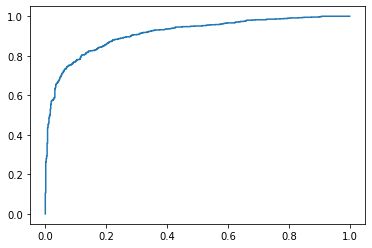

In [272]:
plt.figure()
plt.plot(ffpr_gb,ftpr_gb)

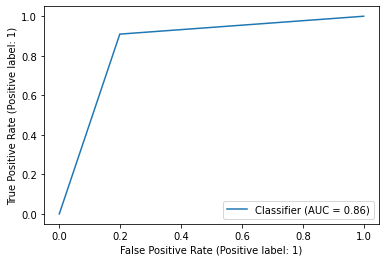

In [273]:
RocCurveDisplay.from_predictions(yf_test,Fgbc_preds)

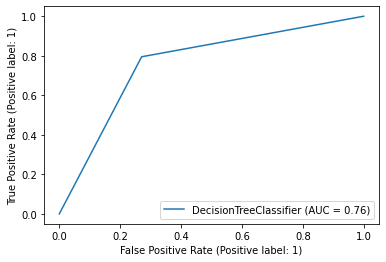

In [274]:
RocCurveDisplay.from_estimator(Fclf,Xf_test,yf_test)

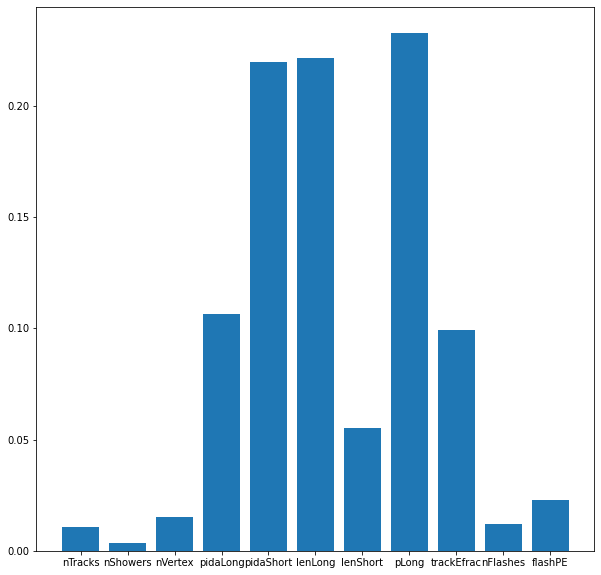

In [275]:
plt.figure(figsize=[10,10])
plt.bar(head_list,Fgbc.feature_importances_)
plt.xlabel="Feature"
plt.ylabel="Importance"
plt.show()

In [276]:
Fgbc.feature_importances_

array([0.01086635, 0.00350667, 0.01499498, 0.10672683, 0.21986575,
       0.22166976, 0.05507417, 0.23287732, 0.09939851, 0.0119784 ,
       0.02304126])

# What about an SVC? 

In [277]:
Fgbc5 = ensemble.GradientBoostingClassifier(learning_rate=.01,n_estimators=10000)
Fgbc5.fit(Xf_train,yf_train)
Fgbc5.score(Xf_test,yf_test)

0.8290123456790124

In [341]:
Fsvc = svm.NuSVC()
Fsvc.fit(Xf_train,yf_train)
Fsvc_score = Fsvc.score(Xf_test,yf_test)
print(Fsvc_score)

0.5259259259259259


In [279]:
FrfC = RandomForestClassifier()
FrfC.fit(Xf_train,yf_train)
FrfC_score=rfC.score(Xf_test,yf_test)
print (FrfC_score)

0.9586419753086419


<BarContainer object of 11 artists>

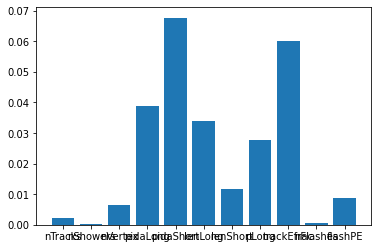

In [280]:
FpImp = permutation_importance(FrfC,Xf_test,yf_test,n_repeats=10,random_state=0)
FpImp_df = pd.DataFrame(columns=['Importance'],index = [i for i in Xf_train.columns])
FpImp_df['Importance']= FpImp.importances_mean
FpImp_df
plt.bar(FpImp_df.index,FpImp_df.Importance)



In [281]:
FNBC = GaussianNB()
FNBC.fit(Xf_train,yf_train)
FNBC_score = NBC.score(Xf_test,yf_test)
print(FNBC_score)

0.7611111111111111


In [282]:
from sklearn.neural_network import MLPClassifier
FnnCLF = MLPClassifier(solver='adam', alpha=1e-5)
FnnCLF.fit(Xf_train,yf_train)
FnnCLF_score = FnnCLF.score(Xf_test,yf_test)

In [283]:
FnnCLF = MLPClassifier(solver = 'adam', learning_rate='invscaling', verbose = 1,random_state=8)
FnnCLF.fit(Xf_train,yf_train)
FnnCLF_score=nnCLF.score(Xf_test,yf_test)
print(FnnCLF_score)

Iteration 1, loss = 4.77965112
Iteration 2, loss = 1.72347693
Iteration 3, loss = 1.04863550
Iteration 4, loss = 0.85532476
Iteration 5, loss = 0.75112821
Iteration 6, loss = 0.70443831
Iteration 7, loss = 0.64806531
Iteration 8, loss = 0.66098834
Iteration 9, loss = 0.62515010
Iteration 10, loss = 0.64080532
Iteration 11, loss = 0.60428253
Iteration 12, loss = 0.58616538
Iteration 13, loss = 0.59407409
Iteration 14, loss = 0.68559431
Iteration 15, loss = 0.58877810
Iteration 16, loss = 0.60641300
Iteration 17, loss = 0.71289849
Iteration 18, loss = 0.59109481
Iteration 19, loss = 0.63239431
Iteration 20, loss = 0.57084607
Iteration 21, loss = 0.64833084
Iteration 22, loss = 0.62194813
Iteration 23, loss = 0.58571539
Iteration 24, loss = 0.68947040
Iteration 25, loss = 0.59800443
Iteration 26, loss = 0.62352079
Iteration 27, loss = 0.58402444
Iteration 28, loss = 0.58824153
Iteration 29, loss = 0.55860869
Iteration 30, loss = 0.56676938
Iteration 31, loss = 0.71825528
Iteration 32, los

# How do the scores match up?

In [284]:
scores_df_dict = {"Classifier":["DecTree","GBC","SVC","NN","RanForest","NaiveBayes"],
                  "Prod":[clf_score,gbc_score,svc_score,nnCLF_score,rfC_score,NBC_score],
                  "Flash Matched":[Fclf_score,Fgbc_score,Fsvc_score,FnnCLF_score,FrfC_score,FNBC_score]}
scores_df=pd.DataFrame(scores_df_dict)
scores_df=scores_df.set_index("Classifier")

<AxesSubplot:xlabel='Classifier', ylabel='Score'>

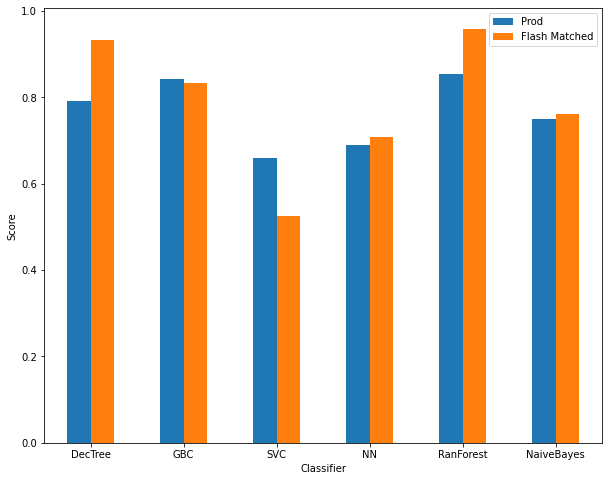

In [285]:
scores_df.plot(kind="bar",figsize=[10,8],ylabel="Score",rot=0)

## Since the parameter space for the PDK is so high, it the 'simpler' models seem to perform better - though, there is very little tuning done here

Text(-0.13766515854440847, flashPE, 'Flash Matched')

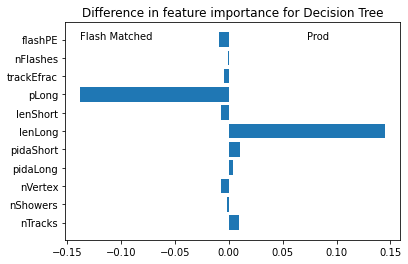

In [286]:
import_diff = clf.feature_importances_ - Fclf.feature_importances_
Flabel_x = import_diff.min()
label_x = (import_diff.max()+import_diff.mean())/2
plt.figure()
plt.barh(head_list,width=import_diff,)
plt.title("Difference in feature importance for Decision Tree")
plt.annotate("Prod",xy=[label_x,"flashPE"])
plt.annotate("Flash Matched",xy=[Flabel_x,"flashPE"])

Text(-0.06630651782120847, flashPE, 'Flash Matched')

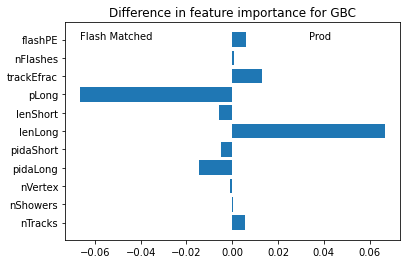

In [287]:
import_diff = gbc.feature_importances_ - Fgbc.feature_importances_
Flabel_x = (import_diff.min())
label_x = (import_diff.max()+import_diff.mean())/2
plt.figure()
plt.barh(head_list,width=import_diff,)
plt.title("Difference in feature importance for GBC")
plt.annotate("Prod",xy=[label_x,"flashPE"])
plt.annotate("Flash Matched",xy=[Flabel_x,"flashPE"])

Text(-0.010466286324544521, flashPE, 'Flash Matched')

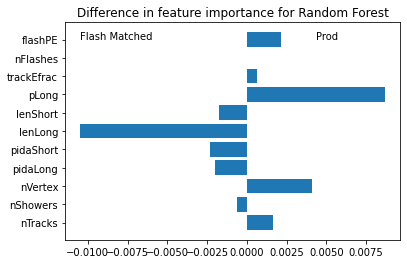

In [288]:
import_diff = rfC.feature_importances_ - FrfC.feature_importances_
Flabel_x = import_diff.min()
label_x = (import_diff.max()+import_diff.mean())/2
plt.figure()
plt.barh(head_list,width=import_diff,)
plt.title("Difference in feature importance for Random Forest")
plt.annotate("Prod",xy=[label_x,"flashPE"])
plt.annotate("Flash Matched",xy=[Flabel_x,"flashPE"])

# It seems the importance of the enery (momentum) increases when better t0 matching (flash matching) is implemented?

Text(-6, 200, 'Kolmogorov-Smirnov test:\n sig(bkg) probability: 0.322 (0.01119)')

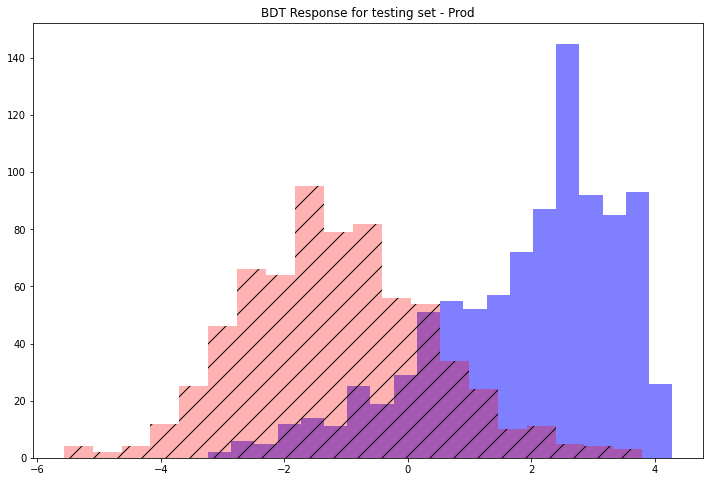

In [289]:
from scipy.stats import ks_2samp
plt.figure(figsize=[12,8])
plotset = X_test.join(y_test)

plotset_sig = plotset[plotset.sig==1].drop('sig',axis=1)
plotset_bckgd = plotset[plotset.sig==0].drop('sig',axis=1)
plt.hist(gbc.decision_function(plotset_sig),color='blue',histtype='bar',alpha=.5,bins=20)
plt.hist(gbc.decision_function(plotset_bckgd),color='red',histtype='bar',alpha=.3,hatch='/',bins=20)
plt.title("BDT Response for testing set - Prod")

trainset = X_train.join(y_train)

trainset_sig = trainset[trainset.sig==1].drop('sig',axis=1)
trainset_bckgd = trainset[trainset.sig==0].drop('sig',axis=1)

sig_kstat, sig_kp = ks_2samp(gbc.decision_function(trainset_sig),gbc.decision_function(plotset_sig))
bkg_kstat, bkg_kp = ks_2samp(gbc.decision_function(trainset_bckgd),gbc.decision_function(plotset_bckgd))
plt.annotate(("Kolmogorov-Smirnov test:\n sig(bkg) probability: "
              +str(round(sig_kp,3))+" ("+str(round(bkg_kp,5))+")"),xy=[-6,200])

Text(-5, 250, 'Kolmogorov-Smirnov test:\n sig(bkg) probability: 0.112 (0.00028)')

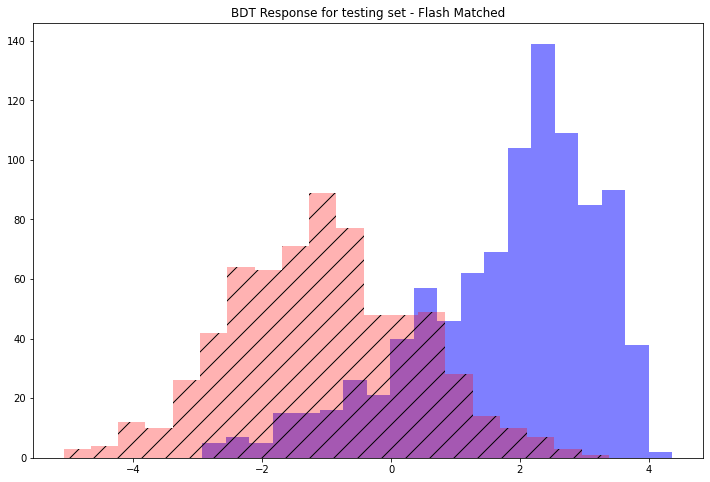

In [290]:
fplotset = Xf_test.join(yf_test)
plt.figure(figsize=[12,8])

fplotset_sig = fplotset[fplotset.sig==1].drop('sig',axis=1)
fplotset_bckgd = fplotset[fplotset.sig==0].drop('sig',axis=1)
plt.hist(Fgbc.decision_function(fplotset_sig),color='blue',histtype='bar',alpha=.5,bins=20)
plt.hist(Fgbc.decision_function(fplotset_bckgd),color='red',histtype='bar',alpha=.3,hatch='/',bins=20)
plt.title("BDT Response for testing set - Flash Matched")

ftrainset = Xf_train.join(yf_train)

ftrainset_sig = ftrainset[ftrainset.sig==1].drop('sig',axis=1)
ftrainset_bckgd = ftrainset[ftrainset.sig==0].drop('sig',axis=1)

fsig_kstat, fsig_kp = ks_2samp(Fgbc.decision_function(ftrainset_sig),Fgbc.decision_function(fplotset_sig))
fbkg_kstat, fbkg_kp = ks_2samp(Fgbc.decision_function(ftrainset_bckgd),Fgbc.decision_function(fplotset_bckgd))
plt.annotate(("Kolmogorov-Smirnov test:\n sig(bkg) probability: "
              +str(round(fsig_kp,3))+" ("+str(round(fbkg_kp,5))+")"),xy=[-5,250])

# OKAY HERE WE HAVE XENON NOW 
## Here is the analysis WITHOUT flash matching

In [291]:
head_list = ["nTracks","nShowers","nVertex","trkE","EmE","pidaLong","pidaShort","lenLong","lenShort","visE","pLong","trackEfrac","nFlashes","flashPE","sig"]
atmo_xenon = pd.read_csv("xenon_atmo.csv",names=head_list,header=None,index_col=False)
pdk_xenon = pd.read_csv("xenon_pdk.csv",names=head_list,header=None,index_col=False)
#pdk_xenon = pdk_xenon[0:2500]
pdk_xenon.count()

nTracks       4512
nShowers      4512
nVertex       4512
trkE          4512
EmE           4512
pidaLong      4512
pidaShort     4512
lenLong       4512
lenShort      4512
visE          4512
pLong         4512
trackEfrac    4512
nFlashes      4512
flashPE       4512
sig           4512
dtype: int64

# Signal and background csvs are imported, as well as necessary libraries. Look to see they have expected behavior.

In [292]:
atmo_xenon.count()

nTracks       1633
nShowers      1633
nVertex       1633
trkE          1633
EmE           1633
pidaLong      1633
pidaShort     1633
lenLong       1633
lenShort      1633
visE          1633
pLong         1633
trackEfrac    1633
nFlashes      1633
flashPE       1633
sig           1633
dtype: int64

In [293]:
pdk_xenon.count()

nTracks       4512
nShowers      4512
nVertex       4512
trkE          4512
EmE           4512
pidaLong      4512
pidaShort     4512
lenLong       4512
lenShort      4512
visE          4512
pLong         4512
trackEfrac    4512
nFlashes      4512
flashPE       4512
sig           4512
dtype: int64

In [294]:
pdk_xdf = atmo_xenon
pdk_xdf=pdk_xdf.append(pdk_xenon,ignore_index=True)
pdk_xdf=pdk_xdf.drop(["trkE","EmE","visE"],axis=1)
pdk_xdf.count()

nTracks       6145
nShowers      6145
nVertex       6145
pidaLong      6145
pidaShort     6145
lenLong       6145
lenShort      6145
pLong         6145
trackEfrac    6145
nFlashes      6145
flashPE       6145
sig           6145
dtype: int64

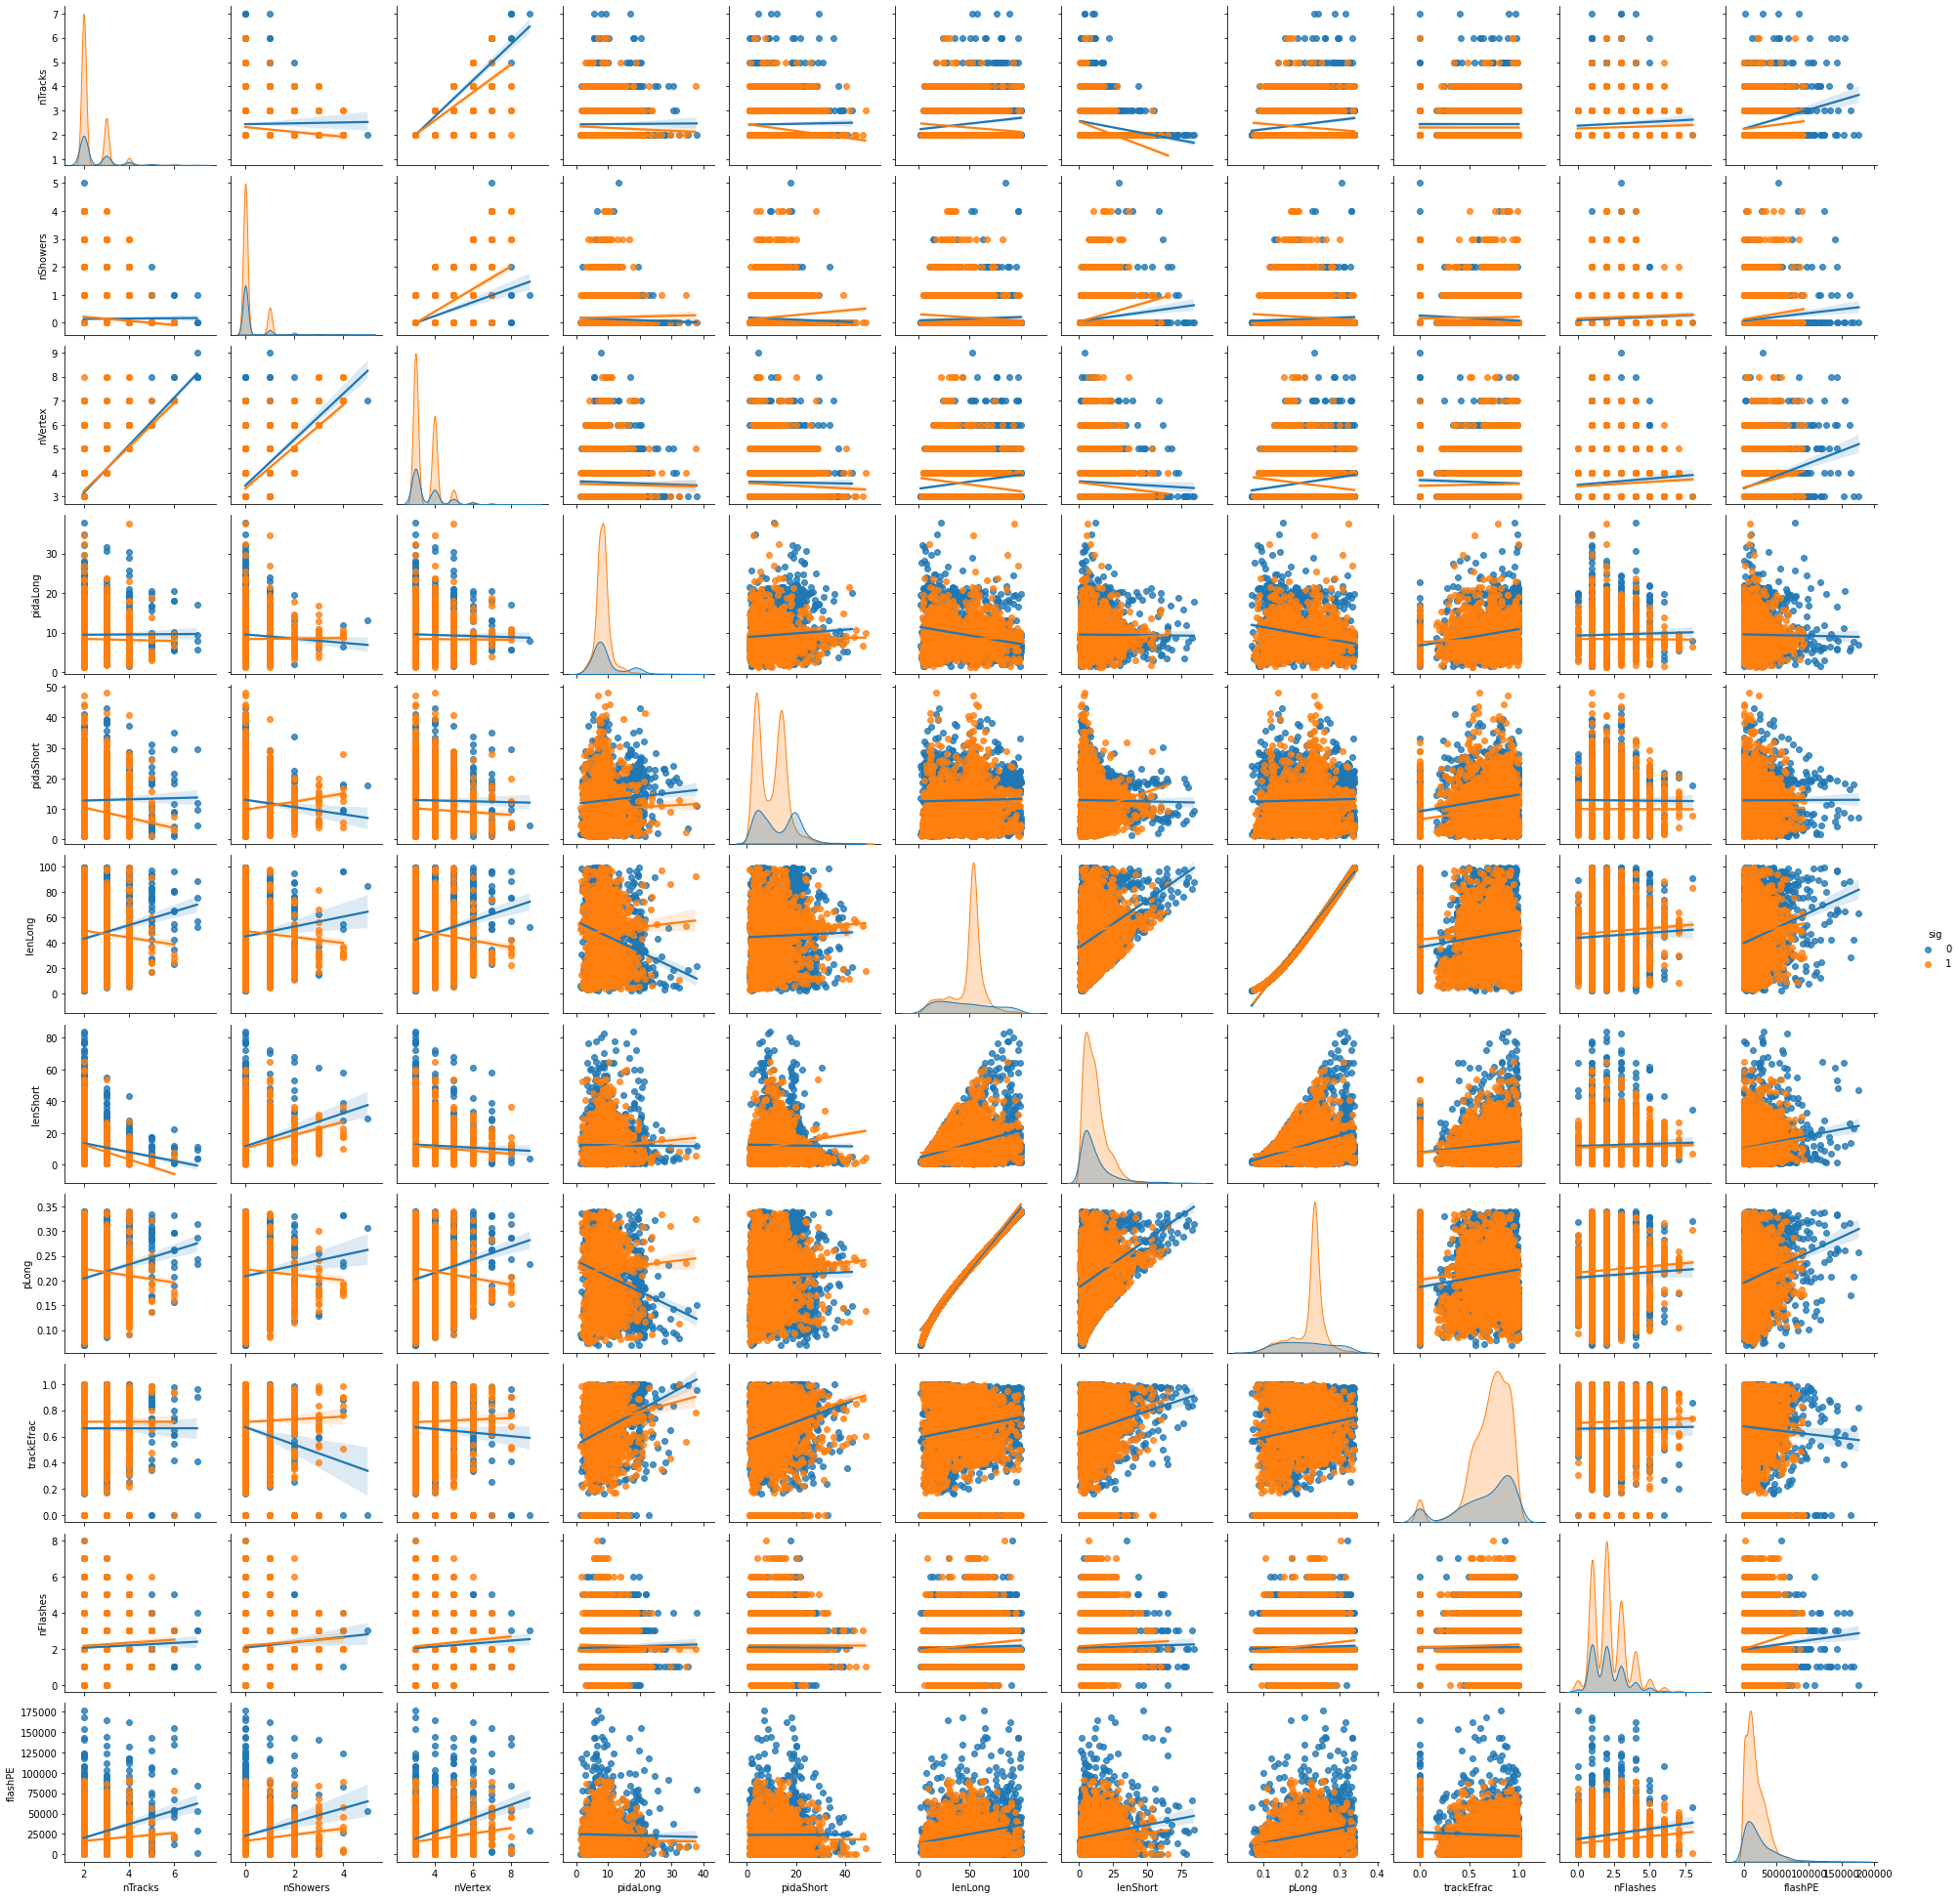

In [295]:
sb.pairplot(data=pdk_xdf,kind="reg",hue="sig")

In [296]:
pdk_xtarget = pdk_xdf.sig
pdk_xtarget

0       0
1       0
2       0
3       0
4       0
       ..
6140    1
6141    1
6142    1
6143    1
6144    1
Name: sig, Length: 6145, dtype: int64

# Pull off the "signal" column to use as the target for our ML models

In [297]:
pdk_xtarget
pdk_xdf=pdk_xdf.drop(["sig"],axis=1)

# Use 70% of the sample as a training set, and split here. Have a look to make sure it makes sense

In [298]:
Xx_train, Xx_test, yx_train, yx_test =train_test_split(pdk_xdf, pdk_xtarget, test_size = 0.3)
Xx_train.head()

nTracks  nShowers  nVertex  pidaLong  pidaShort   lenLong  lenShort  \
1825        2         0        3   9.85697    2.67468  19.65520   3.01543   
2014        2         0        3   6.25252    1.03573  18.49220   1.90792   
208         2         0        3  20.95060   16.66620   5.65768   2.34210   
5069        3         0        4   4.17128    8.42022   8.00910   4.19697   
4165        2         0        3   8.42438    5.57088  24.07000  10.83720   

         pLong  trackEfrac  nFlashes     flashPE  
1825  0.145306    0.307841         2  25358.7000  
2014  0.141674    0.000000         1     47.2186  
208   0.090481    1.000000         4  12263.8000  
5069  0.102307    0.441645         2   6566.5400  
4165  0.158507    0.926046         3  11940.2000

In [299]:
yx_train.head()

1825    1
2014    1
208     0
5069    1
4165    1
Name: sig, dtype: int64

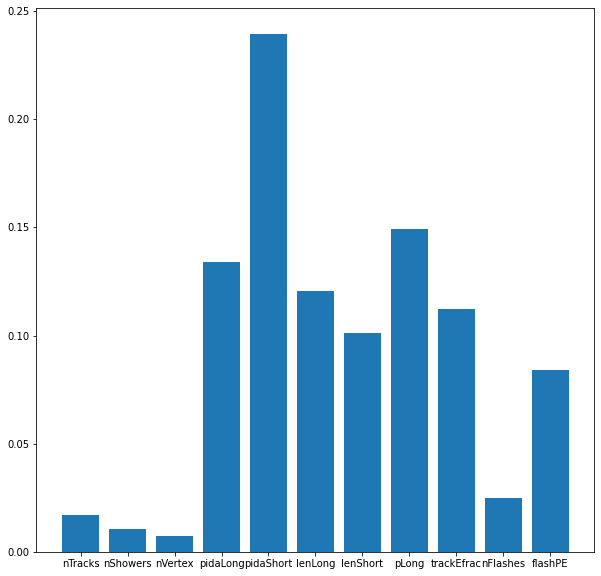

In [300]:
Xclf=tree.DecisionTreeClassifier()
Xclf.fit(Xx_train,yx_train)
Xclf_score= Xclf.score(Xx_test,yx_test)
for i in ["sig","trkE","EmE","visE"]:
    head_list.remove(i)
plt.figure(figsize=[10,10])
plt.bar(head_list,Xclf.feature_importances_)
plt.xlabel="Feature"
plt.ylabel="Importance"
plt.show()

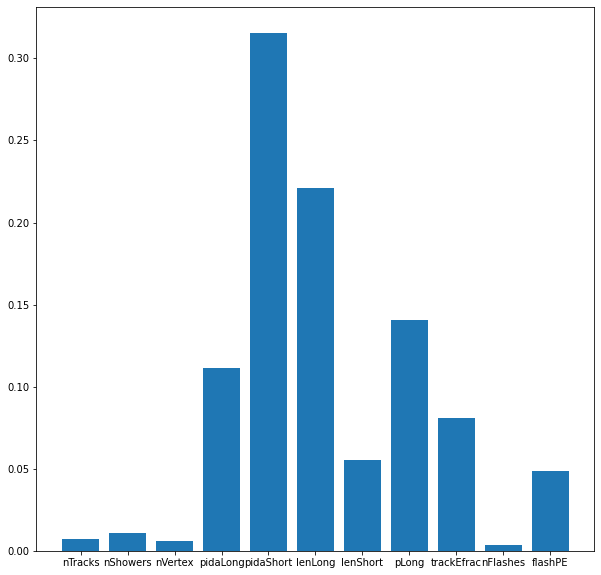

In [301]:
Xgbc = ensemble.GradientBoostingClassifier()
Xgbc.fit(Xx_train,yx_train)
Xgbc_preds=Xgbc.predict(Xx_test)
Xgbc_score = Xgbc.score(Xx_test,yx_test)
plt.figure(figsize=[10,10])
plt.bar(head_list,Xgbc.feature_importances_)
plt.xlabel="Feature"
plt.ylabel="Importance"
plt.show()

In [302]:
Xgbc5 = ensemble.GradientBoostingClassifier(learning_rate=.01,n_estimators=10000)
Xgbc5.fit(Xx_train,yx_train)
Xgbc5.score(Xx_test,yx_test)

0.8329718004338394

In [303]:
Xsvc = svm.NuSVC()
Xsvc.fit(Xx_train,yx_train)
Xsvc_score = Xsvc.score(Xx_test,yx_test)
print(Xsvc_score)

0.5905639913232104


In [304]:
XrfC = RandomForestClassifier()
XrfC.fit(Xx_train,yx_train)
XrfC_score=XrfC.score(Xx_test,yx_test)
print (XrfC_score)

0.8432754880694143


<BarContainer object of 11 artists>

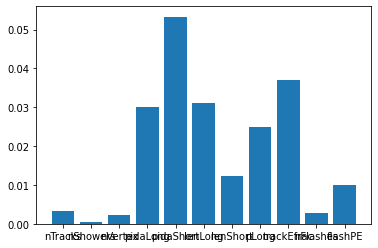

In [305]:
XpImp = permutation_importance(XrfC,Xx_test,yx_test,n_repeats=10,random_state=0)
XpImp_df = pd.DataFrame(columns=['Importance'],index = [i for i in Xx_train.columns])
XpImp_df['Importance']= XpImp.importances_mean
XpImp_df
plt.bar(XpImp_df.index,XpImp_df.Importance)




In [306]:
XNBC = GaussianNB()
XNBC.fit(Xx_train,yx_train)
XNBC_score = XNBC.score(Xx_test,yx_test)
print(XNBC_score)

0.7841648590021691


In [307]:
from sklearn.neural_network import MLPClassifier
XnnCLF = MLPClassifier(solver='adam', alpha=1e-5)
XnnCLF.fit(Xx_train,yx_train)
XnnCLF_score = XnnCLF.score(Xx_test,yx_test)

<AxesSubplot:xlabel='Classifier', ylabel='Score'>

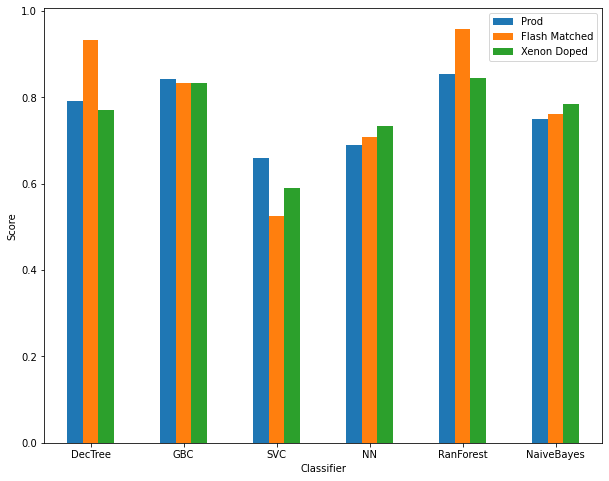

In [308]:
scores_df_dict = {"Classifier":["DecTree","GBC","SVC","NN","RanForest","NaiveBayes"],
                  "Prod":[clf_score,gbc_score,svc_score,nnCLF_score,rfC_score,NBC_score],
                  "Flash Matched":[Fclf_score,Fgbc_score,Fsvc_score,FnnCLF_score,FrfC_score,FNBC_score],
                  "Xenon Doped":[Xclf_score,Xgbc_score,Xsvc_score,XnnCLF_score,XrfC_score,XNBC_score]}
scores_df=pd.DataFrame(scores_df_dict)
scores_df=scores_df.set_index("Classifier")
scores_df.plot(kind="bar",figsize=[10,8],ylabel="Score",rot=0)

Text(-0.08102217623787722, flashPE, 'Xenon Doped')

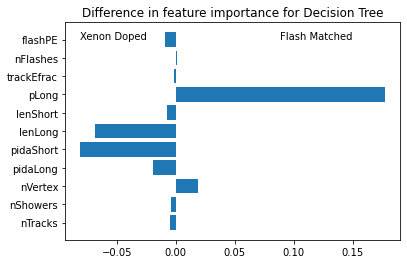

In [309]:
import_diff = Fclf.feature_importances_ - Xclf.feature_importances_
Flabel_x = import_diff.min()
label_x = (import_diff.max()+import_diff.mean())/2
plt.figure()
plt.barh(head_list,width=import_diff,)
plt.title("Difference in feature importance for Decision Tree")
plt.annotate("Flash Matched",xy=[label_x,"flashPE"])
plt.annotate("Xenon Doped",xy=[Flabel_x,"flashPE"])

Text(-0.019071614185792646, flashPE, 'Xenon Doped')

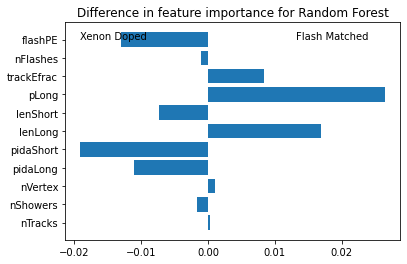

In [310]:
import_diff = FrfC.feature_importances_ - XrfC.feature_importances_
Flabel_x = import_diff.min()
label_x = (import_diff.max()+import_diff.mean())/2
plt.figure()
plt.barh(head_list,width=import_diff,)
plt.title("Difference in feature importance for Random Forest")
plt.annotate("Flash Matched",xy=[label_x,"flashPE"])
plt.annotate("Xenon Doped",xy=[Flabel_x,"flashPE"])

In [311]:
Xx_test.count()

nTracks       1844
nShowers      1844
nVertex       1844
pidaLong      1844
pidaShort     1844
lenLong       1844
lenShort      1844
pLong         1844
trackEfrac    1844
nFlashes      1844
flashPE       1844
dtype: int64

Text(-6, 200, 'Kolmogorov-Smirnov test:\n sig(bkg) probability: 0.12 (0.00467)')

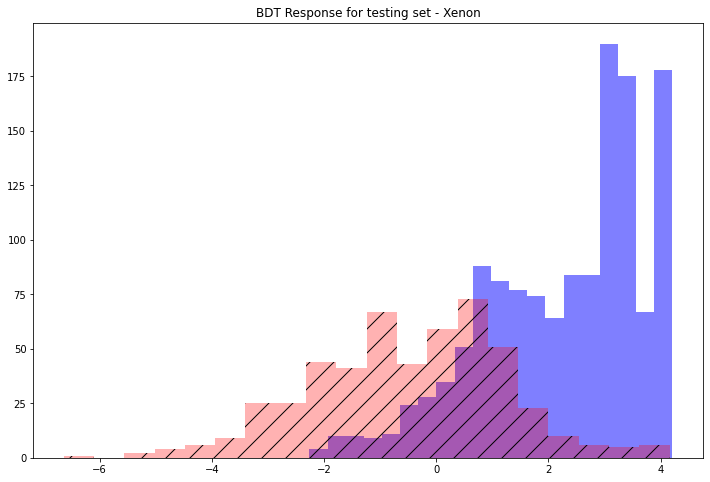

In [312]:
plt.figure(figsize=[12,8])
plotset = Xx_test.join(yx_test)

plotset_sig = plotset[plotset.sig==1].drop('sig',axis=1)
plotset_bckgd = plotset[plotset.sig==0].drop('sig',axis=1)
plt.hist(Xgbc.decision_function(plotset_sig),color='blue',histtype='bar',alpha=.5,bins=20)
plt.hist(Xgbc.decision_function(plotset_bckgd),color='red',histtype='bar',alpha=.3,hatch='/',bins=20)
plt.title("BDT Response for testing set - Xenon")

trainset = Xx_train.join(yx_train)

trainset_sig = trainset[trainset.sig==1].drop('sig',axis=1)
trainset_bckgd = trainset[trainset.sig==0].drop('sig',axis=1)

sig_kstat, sig_kp = ks_2samp(Xgbc.decision_function(trainset_sig),Xgbc.decision_function(plotset_sig))
bkg_kstat, bkg_kp = ks_2samp(Xgbc.decision_function(trainset_bckgd),Xgbc.decision_function(plotset_bckgd))
plt.annotate(("Kolmogorov-Smirnov test:\n sig(bkg) probability: "
              +str(round(sig_kp,3))+" ("+str(round(bkg_kp,5))+")"),xy=[-6,200])

# OKAY HERE WE HAVE XENON NOW
## Here is the analysis WITH flash matching

In [313]:
head_list = ["nTracks","nShowers","nVertex","trkE","EmE","pidaLong","pidaShort","lenLong","lenShort","visE","pLong","trackEfrac","nFlashes","flashPE","sig"]
atmo_fxenon = pd.read_csv("xenon_atmo_flash.csv",names=head_list,header=None,index_col=False)
pdk_fxenon = pd.read_csv("xenon_pdk_flash.csv",names=head_list,header=None,index_col=False)
#pdk_fxenon = pdk_fxenon[0:2500]
pdk_fxenon.count()

nTracks       4222
nShowers      4222
nVertex       4222
trkE          4222
EmE           4222
pidaLong      4222
pidaShort     4222
lenLong       4222
lenShort      4222
visE          4222
pLong         4222
trackEfrac    4222
nFlashes      4222
flashPE       4222
sig           4222
dtype: int64

# Signal and background csvs are imported, as well as necessary libraries. Look to see they have expected behavior.

In [314]:
atmo_fxenon.count()

nTracks       1568
nShowers      1568
nVertex       1568
trkE          1568
EmE           1568
pidaLong      1568
pidaShort     1568
lenLong       1568
lenShort      1568
visE          1568
pLong         1568
trackEfrac    1568
nFlashes      1568
flashPE       1568
sig           1568
dtype: int64

In [315]:
pdk_fxenon.count()

nTracks       4222
nShowers      4222
nVertex       4222
trkE          4222
EmE           4222
pidaLong      4222
pidaShort     4222
lenLong       4222
lenShort      4222
visE          4222
pLong         4222
trackEfrac    4222
nFlashes      4222
flashPE       4222
sig           4222
dtype: int64

In [316]:
pdk_xfdf = atmo_fxenon
pdk_xfdf=pdk_xfdf.append(pdk_fxenon,ignore_index=True)
pdk_xfdf=pdk_xfdf.drop(["trkE","EmE","visE"],axis=1)
pdk_xfdf.count()

nTracks       5790
nShowers      5790
nVertex       5790
pidaLong      5790
pidaShort     5790
lenLong       5790
lenShort      5790
pLong         5790
trackEfrac    5790
nFlashes      5790
flashPE       5790
sig           5790
dtype: int64

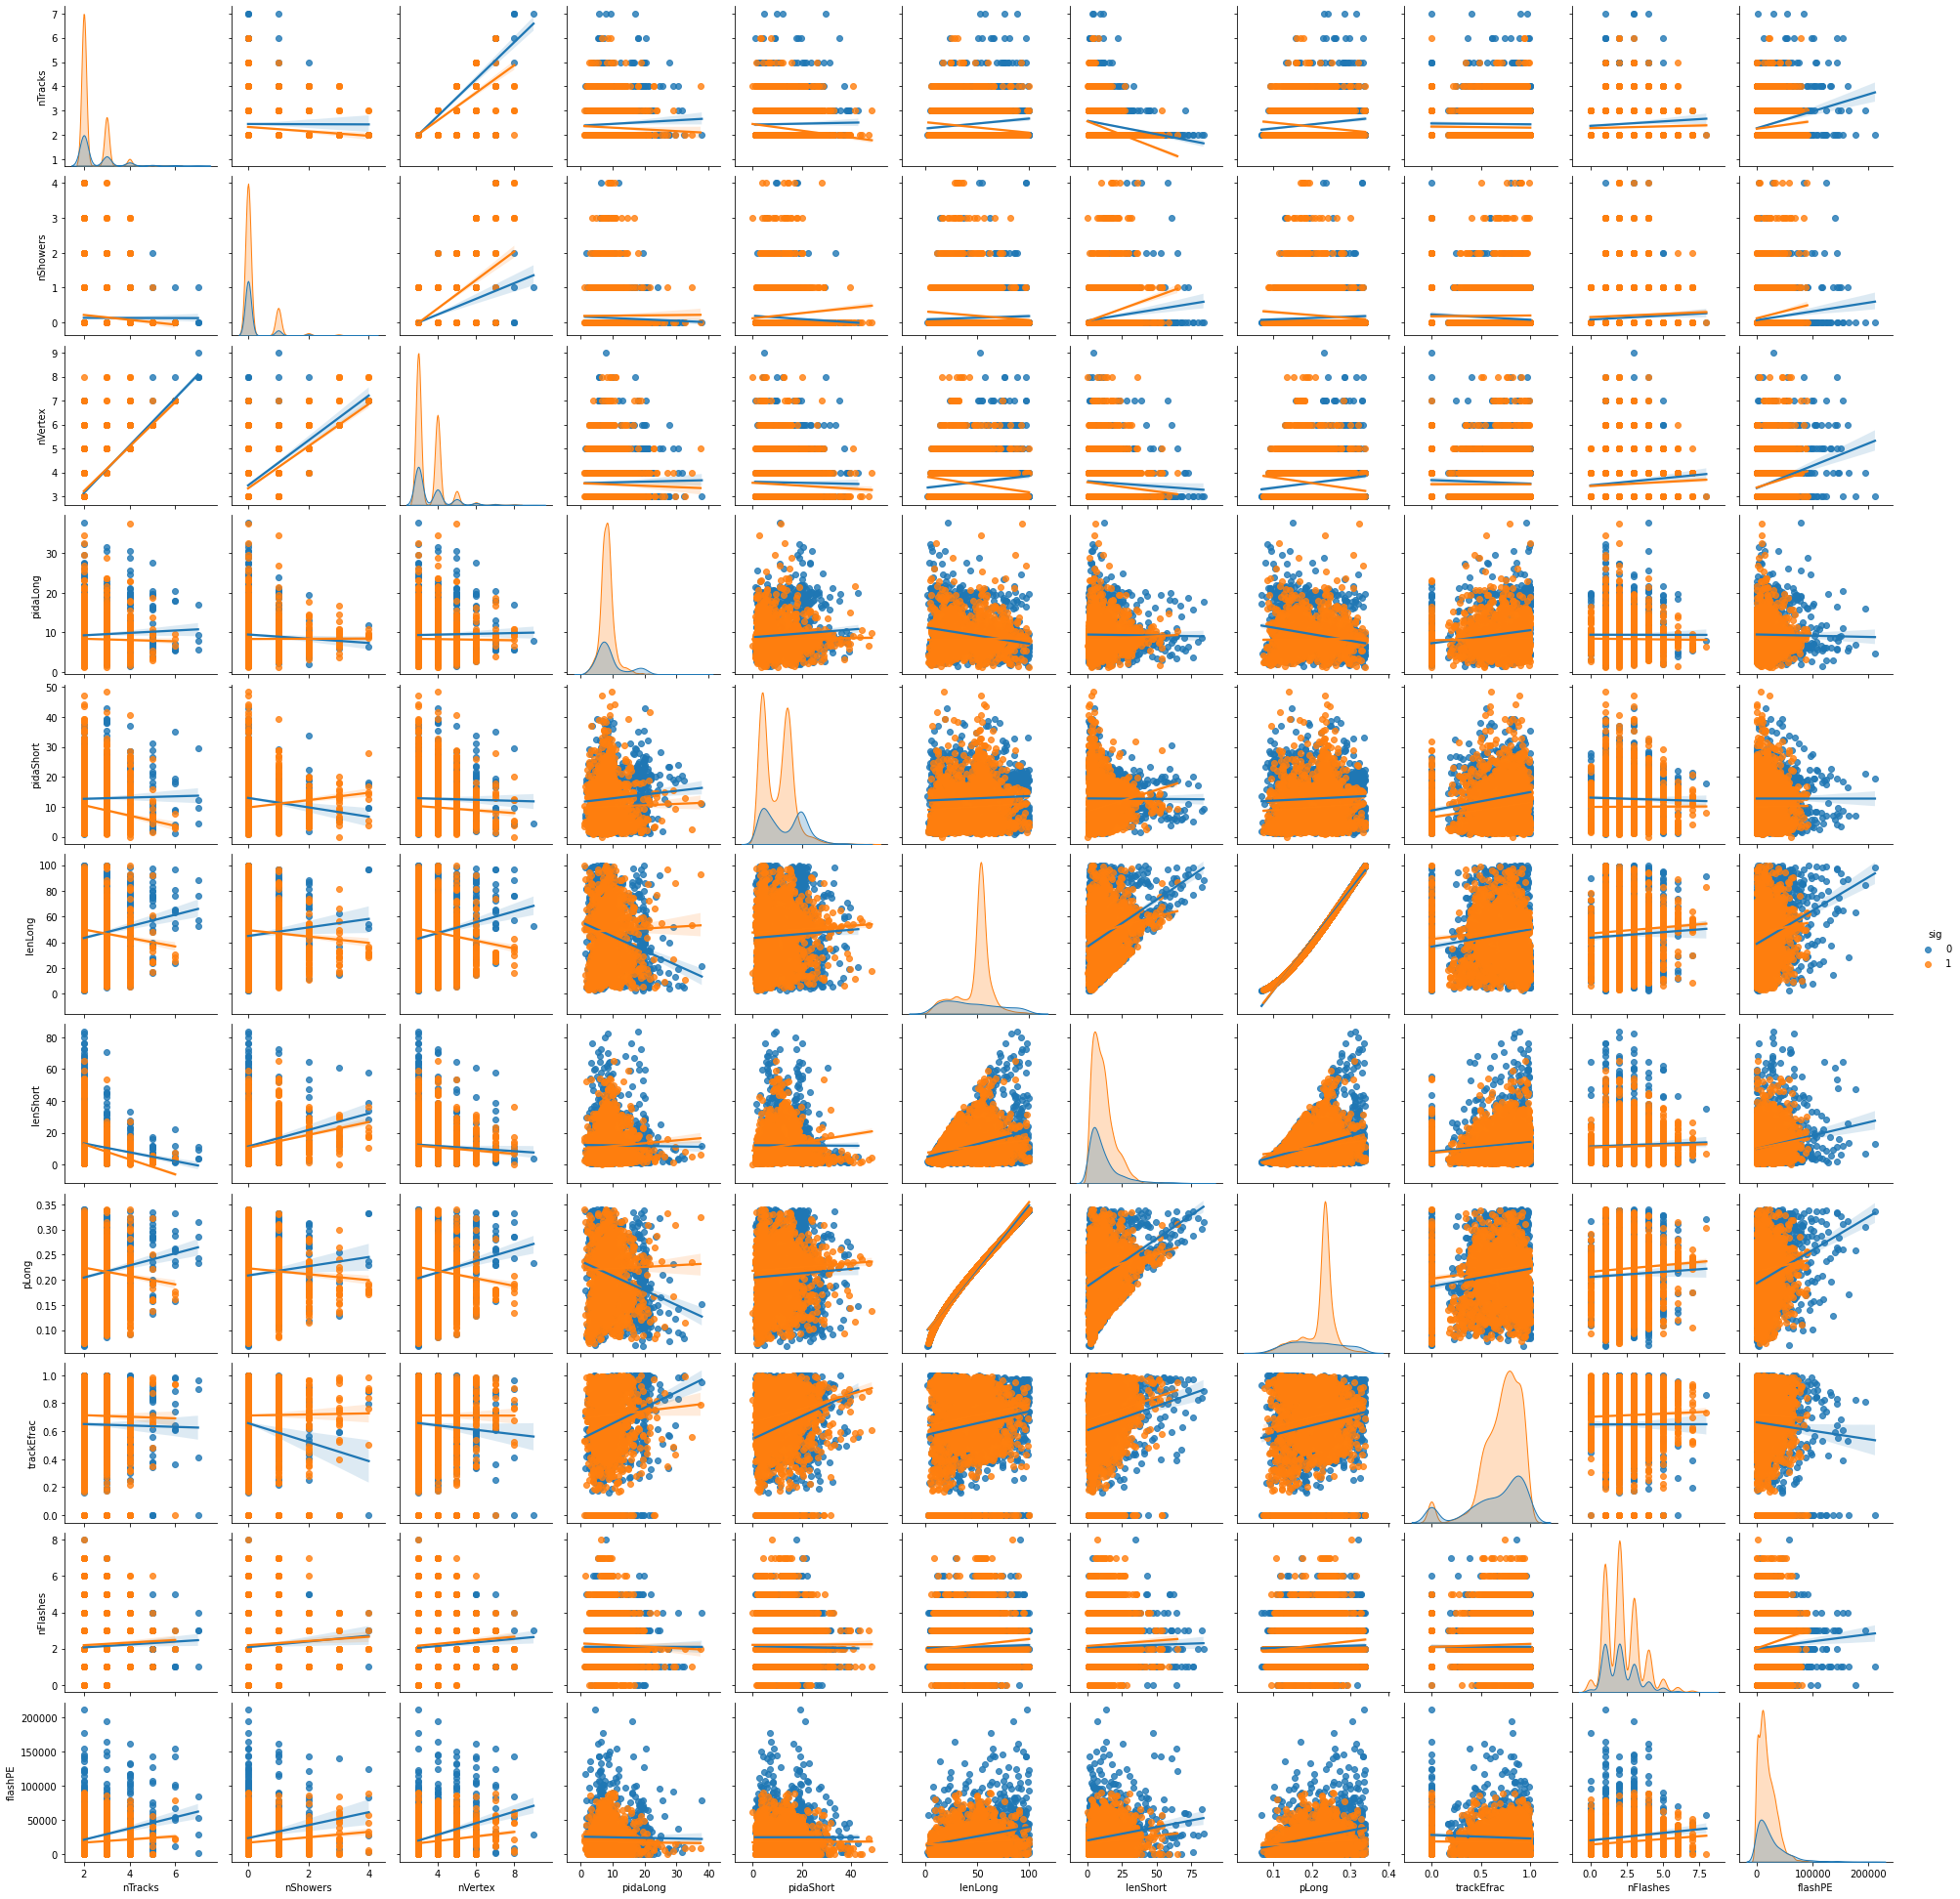

In [317]:
sb.pairplot(data=pdk_xfdf,kind="reg",hue="sig")

In [318]:
pdk_xftarget = pdk_xfdf.sig
pdk_xftarget

0       0
1       0
2       0
3       0
4       0
       ..
5785    1
5786    1
5787    1
5788    1
5789    1
Name: sig, Length: 5790, dtype: int64

# Pull off the "signal" column to use as the target for our ML models

In [319]:
pdk_xftarget
pdk_xfdf=pdk_xfdf.drop(["sig"],axis=1)

# Use 70% of the sample as a training set, and split here. Have a look to make sure it makes sense

In [320]:
Xxf_train, Xxf_test, yxf_train, yxf_test =train_test_split(pdk_xfdf, pdk_xftarget, test_size = 0.3)
Xxf_train.head()

nTracks  nShowers  nVertex  pidaLong  pidaShort  lenLong  lenShort  \
1703        2         0        3  10.84550   11.79230  55.2544  14.46920   
4595        2         0        3   9.47355   13.95360  65.8665  19.94010   
4794        2         1        4   7.11081   15.58260  51.6161  22.34420   
3872        2         0        3   4.54136    8.31104  11.1573   7.03011   
1698        2         1        4   1.35364   10.28450  54.9876  14.55670   

         pLong  trackEfrac  nFlashes    flashPE  
1703  0.238637    0.705330         2  16109.000  
4595  0.263397    0.819564         1  32761.400  
4794  0.229975    0.962133         3  22387.400  
3872  0.115868    0.882253         2    171.797  
1698  0.238005    0.529546         2  27127.900

In [321]:
yxf_train.head()

1703    1
4595    1
4794    1
3872    1
1698    1
Name: sig, dtype: int64

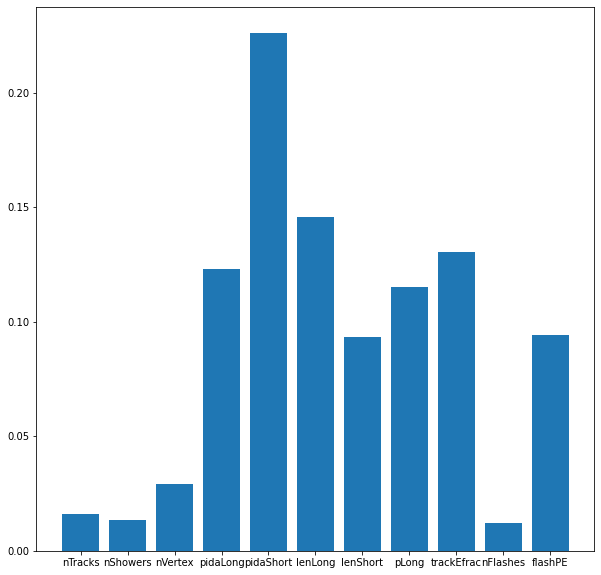

In [322]:
Xfclf=tree.DecisionTreeClassifier()
Xfclf.fit(Xxf_train,yxf_train)
Xfclf_score= Xfclf.score(Xxf_test,yxf_test)
for i in ["sig","trkE","EmE","visE"]:
    head_list.remove(i)
plt.figure(figsize=[10,10])
plt.bar(head_list,Xfclf.feature_importances_)
plt.xlabel="Feature"
plt.ylabel="Importance"
plt.show()

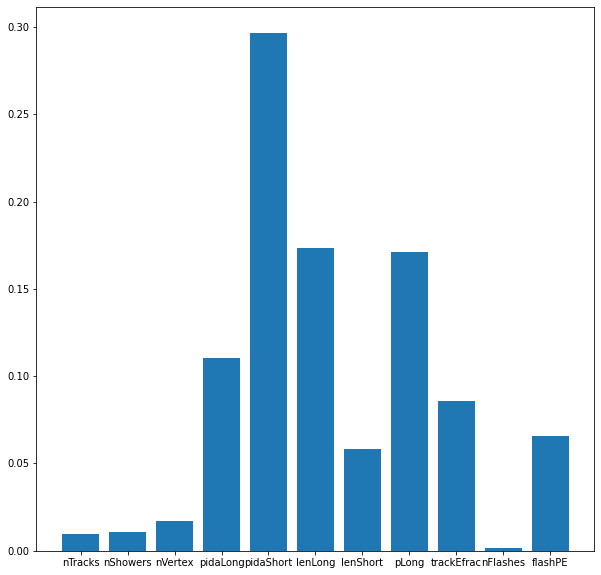

In [323]:
Xfgbc = ensemble.GradientBoostingClassifier()
Xfgbc.fit(Xxf_train,yxf_train)
Xfgbc_preds=Xfgbc.predict(Xxf_test)
Xfgbc_score = Xfgbc.score(Xxf_test,yxf_test)
plt.figure(figsize=[10,10])
plt.bar(head_list,Xfgbc.feature_importances_)
plt.xlabel="Feature"
plt.ylabel="Importance"
plt.show()

In [324]:
Xfgbc5 = ensemble.GradientBoostingClassifier(learning_rate=.01,n_estimators=10000)
Xfgbc5.fit(Xxf_train,yxf_train)
Xfgbc5.score(Xxf_test,yxf_test)

0.8485895221646517

In [325]:
Xfsvc = svm.NuSVC()
Xfsvc.fit(Xxf_train,yxf_train)
Xfsvc_score = Xfsvc.score(Xxf_test,yxf_test)
print(Xfsvc_score)

0.6234887737478411


In [326]:
XfrfC = RandomForestClassifier()
XfrfC.fit(Xxf_train,yxf_train)
XfrfC_score=XfrfC.score(Xxf_test,yxf_test)
print (XfrfC_score)

0.8330454807138745


<BarContainer object of 11 artists>

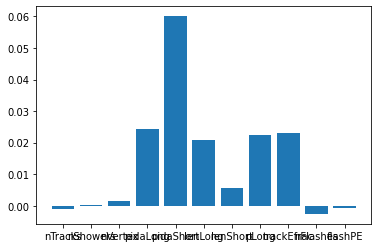

In [327]:
XfpImp = permutation_importance(XfrfC,Xxf_test,yxf_test,n_repeats=10,random_state=0)
XfpImp_df = pd.DataFrame(columns=['Importance'],index = [i for i in Xxf_train.columns])
XfpImp_df['Importance']= XfpImp.importances_mean
XfpImp_df
plt.bar(XfpImp_df.index,XfpImp_df.Importance)




In [328]:
XfNBC = GaussianNB()
XfNBC.fit(Xxf_train,yxf_train)
XfNBC_score = XfNBC.score(Xxf_test,yxf_test)
print(XfNBC_score)

0.7766263672999424


In [329]:
from sklearn.neural_network import MLPClassifier
XfnnCLF = MLPClassifier(solver='adam', alpha=1e-5)
XfnnCLF.fit(Xxf_train,yxf_train)
XfnnCLF_score = XfnnCLF.score(Xxf_test,yxf_test)

<AxesSubplot:xlabel='Classifier', ylabel='Score'>

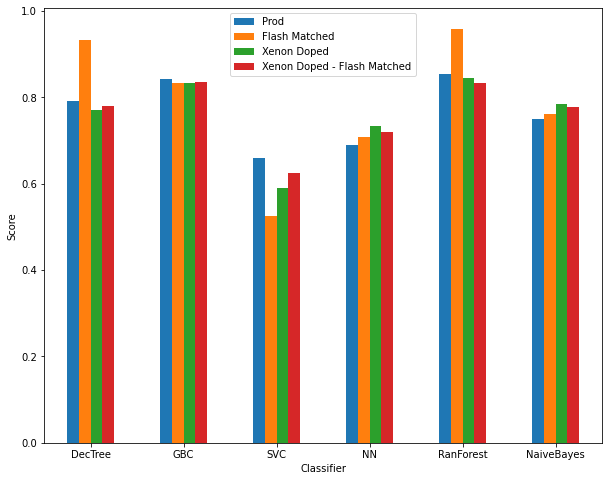

In [330]:
scores_df_dict = {"Classifier":["DecTree","GBC","SVC","NN","RanForest","NaiveBayes"],
                  "Prod":[clf_score,gbc_score,svc_score,nnCLF_score,rfC_score,NBC_score],
                  "Flash Matched":[Fclf_score,Fgbc_score,Fsvc_score,FnnCLF_score,FrfC_score,FNBC_score],
                  "Xenon Doped":[Xclf_score,Xgbc_score,Xsvc_score,XnnCLF_score,XrfC_score,XNBC_score],
                  "Xenon Doped - Flash Matched":[Xfclf_score,Xfgbc_score,Xfsvc_score,XfnnCLF_score,XfrfC_score,XfNBC_score]}
scores_df=pd.DataFrame(scores_df_dict)
scores_df=scores_df.set_index("Classifier")
scores_df.plot(kind="bar",figsize=[10,8],ylabel="Score",rot=0)

Text(-0.0337012747328137, flashPE, 'Xenon Doped')

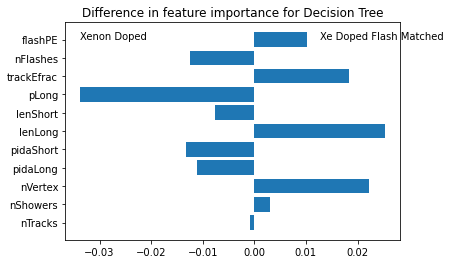

In [331]:
import_diff = Xfclf.feature_importances_ - Xclf.feature_importances_
Flabel_x = import_diff.min()
label_x = (import_diff.max()+import_diff.mean())/2
plt.figure()
plt.barh(head_list,width=import_diff,)
plt.title("Difference in feature importance for Decision Tree")
plt.annotate("Xe Doped Flash Matched",xy=[label_x,"flashPE"])
plt.annotate("Xenon Doped",xy=[Flabel_x,"flashPE"])

Text(-0.013843265321391351, flashPE, 'Xenon Doped')

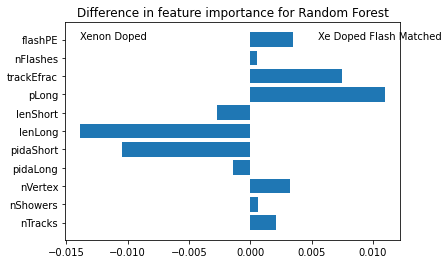

In [332]:
import_diff = XfrfC.feature_importances_ - XrfC.feature_importances_
Flabel_x = import_diff.min()
label_x = (import_diff.max()+import_diff.mean())/2
plt.figure()
plt.barh(head_list,width=import_diff,)
plt.title("Difference in feature importance for Random Forest")
plt.annotate("Xe Doped Flash Matched",xy=[label_x,"flashPE"])
plt.annotate("Xenon Doped",xy=[Flabel_x,"flashPE"])

Text(-0.030253429013945954, flashPE, 'Xenon Doped - Flash Matched')

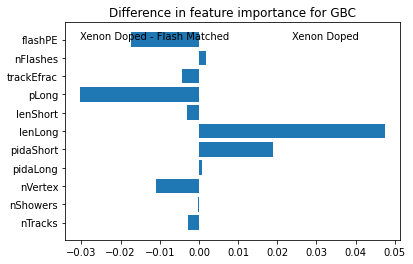

In [333]:
import_diff = Xgbc.feature_importances_ - Xfgbc.feature_importances_
Flabel_x = (import_diff.min())
label_x = (import_diff.max()+import_diff.mean())/2
plt.figure()
plt.barh(head_list,width=import_diff,)
plt.title("Difference in feature importance for GBC")
plt.annotate("Xenon Doped",xy=[label_x,"flashPE"])
plt.annotate("Xenon Doped - Flash Matched",xy=[Flabel_x,"flashPE"])

In [334]:
Xx_test.count()

nTracks       1844
nShowers      1844
nVertex       1844
pidaLong      1844
pidaShort     1844
lenLong       1844
lenShort      1844
pLong         1844
trackEfrac    1844
nFlashes      1844
flashPE       1844
dtype: int64

Text(-6, 200, 'Kolmogorov-Smirnov test:\n sig(bkg) probability: 0.174 (0.0291)')

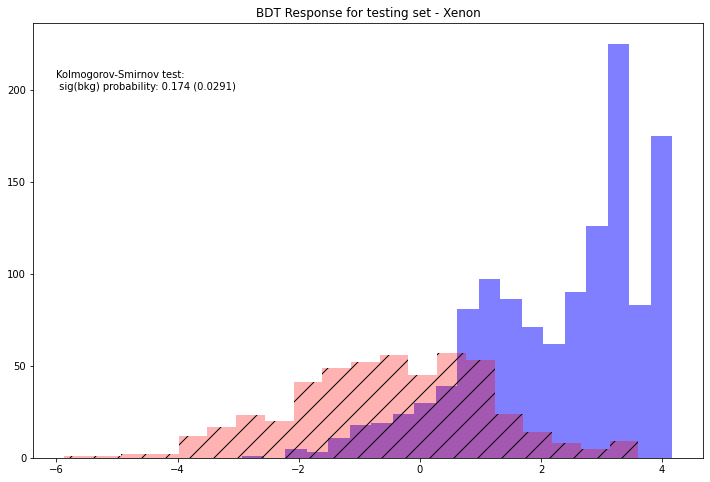

In [335]:
plt.figure(figsize=[12,8])
plotset = Xxf_test.join(yxf_test)

plotset_sig = plotset[plotset.sig==1].drop('sig',axis=1)
plotset_bckgd = plotset[plotset.sig==0].drop('sig',axis=1)
plt.hist(Xfgbc.decision_function(plotset_sig),color='blue',histtype='bar',alpha=.5,bins=20)
plt.hist(Xfgbc.decision_function(plotset_bckgd),color='red',histtype='bar',alpha=.3,hatch='/',bins=20)
plt.title("BDT Response for testing set - Xenon")

trainset = Xxf_train.join(yxf_train)

trainset_sig = trainset[trainset.sig==1].drop('sig',axis=1)
trainset_bckgd = trainset[trainset.sig==0].drop('sig',axis=1)

sig_kstat, sig_kp = ks_2samp(Xfgbc.decision_function(trainset_sig),Xfgbc.decision_function(plotset_sig))
bkg_kstat, bkg_kp = ks_2samp(Xfgbc.decision_function(trainset_bckgd),Xfgbc.decision_function(plotset_bckgd))
plt.annotate(("Kolmogorov-Smirnov test:\n sig(bkg) probability: "
              +str(round(sig_kp,3))+" ("+str(round(bkg_kp,5))+")"),xy=[-6,200])

(array([ 231., 1084.,  695.,  442.,  344.,  439.,  823.,  316.,  316.,
         291.,  180.,   95.,   57.,   28.,   25.,   14.,    6.,    8.,
           3.,    3.]),
 array([ 0.     ,  2.47463,  4.94926,  7.42389,  9.89852, 12.37315,
        14.84778, 17.32241, 19.79704, 22.27167, 24.7463 , 27.22093,
        29.69556, 32.17019, 34.64482, 37.11945, 39.59408, 42.06871,
        44.54334, 47.01797, 49.4926 ]),
 <BarContainer object of 20 artists>)

<Figure size 1440x1440 with 0 Axes>

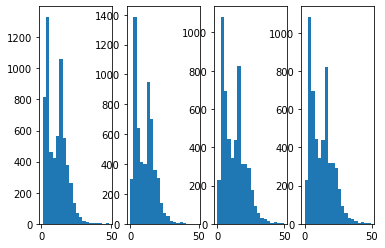

In [336]:
plt.figure(figsize=[20,20])
#plt.plot(pdk_xdf.pidaShort)
fig, ((ax0, ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=4)
ax0.hist(pdk_xdf.pidaShort[:],bins=20)
ax1.hist(pdk_xfdf.pidaShort[:],bins=20)
ax2.hist(pdk_df.pidaShort[:],bins=20)
ax3.hist(pdk_fdf.pidaShort[:],bins=20)


(array([6.900e+01, 3.150e+02, 9.740e+02, 2.036e+03, 1.128e+03, 2.110e+02,
        1.470e+02, 1.010e+02, 1.340e+02, 1.360e+02, 8.500e+01, 3.400e+01,
        1.000e+01, 9.000e+00, 6.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([ 1.14293  ,  3.2721885,  5.401447 ,  7.5307055,  9.659964 ,
        11.7892225, 13.918481 , 16.0477395, 18.176998 , 20.3062565,
        22.435515 , 24.5647735, 26.694032 , 28.8232905, 30.952549 ,
        33.0818075, 35.211066 , 37.3403245, 39.469583 , 41.5988415,
        43.7281   ]),
 <BarContainer object of 20 artists>)

<Figure size 1440x1440 with 0 Axes>

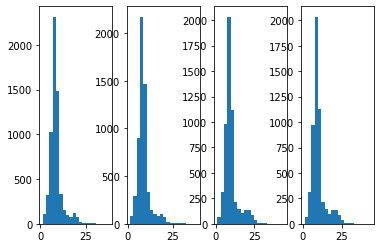

In [337]:
plt.figure(figsize=[20,20])
#plt.plot(pdk_xdf.pidaShort)
fig, ((ax0, ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=4)
ax0.hist(pdk_xdf.pidaLong[:],bins=20)
ax1.hist(pdk_xfdf.pidaLong[:],bins=20)
ax2.hist(pdk_df.pidaLong[:],bins=20)
ax3.hist(pdk_fdf.pidaLong[:],bins=20)

(array([  71.,  185.,  269.,  267.,  272.,  265.,  236.,  255.,  222.,
         426., 1477.,  527.,  251.,  173.,  125.,   91.,   87.,   71.,
          68.,   62.]),
 array([ 1.64892 ,  6.560349, 11.471778, 16.383207, 21.294636, 26.206065,
        31.117494, 36.028923, 40.940352, 45.851781, 50.76321 , 55.674639,
        60.586068, 65.497497, 70.408926, 75.320355, 80.231784, 85.143213,
        90.054642, 94.966071, 99.8775  ]),
 <BarContainer object of 20 artists>)

<Figure size 1440x1440 with 0 Axes>

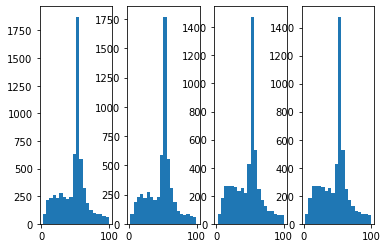

In [338]:
plt.figure(figsize=[20,20])
#plt.plot(pdk_xdf.pidaShort)
fig, ((ax0, ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=4)
ax0.hist(pdk_xdf.lenLong[:],bins=20)
ax1.hist(pdk_xfdf.lenLong[:],bins=20)
ax2.hist(pdk_df.lenLong[:],bins=20)
ax3.hist(pdk_fdf.lenLong[:],bins=20)

(array([1.263e+03, 1.514e+03, 1.006e+03, 6.550e+02, 3.610e+02, 2.310e+02,
        1.320e+02, 7.400e+01, 6.200e+01, 3.100e+01, 1.800e+01, 2.400e+01,
        1.300e+01, 3.000e+00, 2.000e+00, 3.000e+00, 5.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00]),
 array([ 0.      ,  4.500815,  9.00163 , 13.502445, 18.00326 , 22.504075,
        27.00489 , 31.505705, 36.00652 , 40.507335, 45.00815 , 49.508965,
        54.00978 , 58.510595, 63.01141 , 67.512225, 72.01304 , 76.513855,
        81.01467 , 85.515485, 90.0163  ]),
 <BarContainer object of 20 artists>)

<Figure size 1440x1440 with 0 Axes>

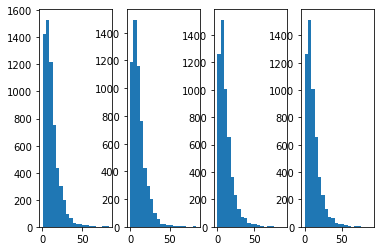

In [339]:
plt.figure(figsize=[20,20])
#plt.plot(pdk_xdf.pidaShort)
fig, ((ax0, ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=4)
ax0.hist(pdk_xdf.lenShort[:],bins=20)
ax1.hist(pdk_xfdf.lenShort[:],bins=20)
ax2.hist(pdk_df.lenShort[:],bins=20)
ax3.hist(pdk_fdf.lenShort[:],bins=20)

(array([  11.,   27.,   75.,  138.,  213.,  215.,  277.,  247.,  278.,
         260.,  267.,  477., 1640.,  483.,  240.,  168.,  113.,  106.,
          91.,   74.]),
 array([0.0607314 , 0.07468403, 0.08863666, 0.10258929, 0.11654192,
        0.13049455, 0.14444718, 0.15839981, 0.17235244, 0.18630507,
        0.2002577 , 0.21421033, 0.22816296, 0.24211559, 0.25606822,
        0.27002085, 0.28397348, 0.29792611, 0.31187874, 0.32583137,
        0.339784  ]),
 <BarContainer object of 20 artists>)

<Figure size 1440x1440 with 0 Axes>

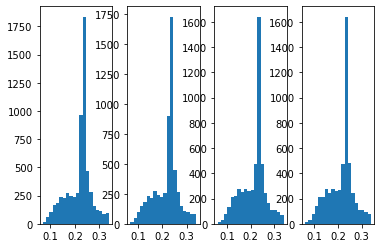

In [340]:
plt.figure(figsize=[20,20])
#plt.plot(pdk_xdf.pidaShort)
fig, ((ax0, ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=4)
ax0.hist(pdk_xdf.pLong[:],bins=20)
ax1.hist(pdk_xfdf.pLong[:],bins=20)
ax2.hist(pdk_df.pLong[:],bins=20)
ax3.hist(pdk_fdf.pLong[:],bins=20)